# Integration with adult Pan-immune data - Myeloid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import time

Global seed set to 0


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv

In [5]:
## import utils
cwd = '../utils/scArches_utils'
sys.path.append(cwd)

import map_query_utils

In [6]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_myeloid_v2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


In [7]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [8]:
%load_ext rpy2.ipython


In [9]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [10]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

## Prepare data for mapping 

### Load full PIP dataset 

Provided by Cecilia, and re-saved by me to have EnsemblIDs as `var_names`

In [9]:
pi_adata = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/panimmune_query.h5ad')

### Subset to lymphoid cells

In [10]:
mye_pi_adata = pi_adata[~pi_adata.obs["anno_mye"].isna()]

In [16]:
mye_pi_adata

View of AnnData object with n_obs × n_vars = 13062 × 33694
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'empty', 'bonf_pval', 'is_doublet', 'scrublet_score', 'louvain', 'louvain_R', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'leiden5', 'leiden10', 'leiden15', 'leiden20', 'cx1_anno', 'leiden_majority_anno', 'leiden1.5', 'anno', 'anno_mye', 'anno_T_2', 'anno_B_v2'
    var: 'gene_ids', 'feature_types', 'gene_names'

In [12]:
mye_pi_adata.write_h5ad("/nfs/team205/ed6/data/Fetal_immune/panimmune_MYELOID_query.h5ad")
mye_pi_adata.write_h5ad("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/panimmune_MYELOID_query.h5ad")

### Save MYELOID scVI model with EnsemblIDs

In [12]:
split = "MYELOID_V2"
timestamp="20210429"
scvi_outs_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'

## Read old varnames
model_dir='scvi_' + split + '_model/'
var_names_model = pd.read_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None)[0].values

## Make new model folder for model with EnsemblIDs
new_model_dir = model_dir.strip("/") +"_ENSID/"
bash_call = 'cp -r {o} {n}'.format(o=scvi_outs_dir + model_dir, n=scvi_outs_dir+new_model_dir)
os.system(bash_call)

## Save var_names
adata_ref_var = pd.read_csv(scvi_outs_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)
adata_ref_var.iloc[var_names_model]['GeneID'].to_csv(scvi_outs_dir + new_model_dir + "var_names.csv", header=None, index=False)

### Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [19]:
merged_adata_file = 'panimmune_full_MYELOID_query.mapped2MYELOID_NEW.withReference.h5ad'
split = "MYELOID_NEW"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
data_dir ="/nfs/team205/ed6/data/Fetal_immune/"
timestamp = '20210429'

In [20]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [21]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values

merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [22]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
query_anno_obs = merged_adata[query_obs].obs.copy()
merged_adata.obs["annotation_query"] = np.nan
df = query_anno_obs.loc[query_obs][["Category"]].astype("str").replace("nan", np.nan)
merged_adata.obs.loc[query_obs, "annotation_query"] = df["Category"].loc[query_obs].values

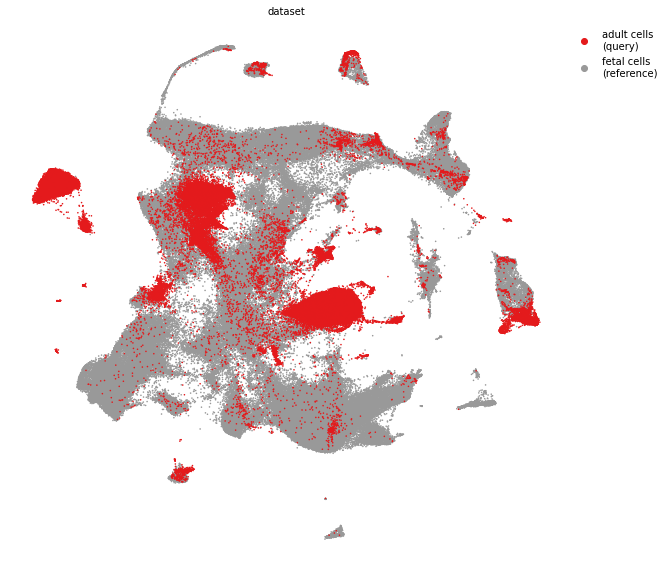

In [23]:
plt.rcParams["figure.figsize"] = [10,10]
merged_adata.obs['dataset_pl'] = ['fetal cells\n(reference)' if x=='reference' else 'adult cells\n(query)' for x in merged_adata.obs['dataset']]
scv.pl.umap(merged_adata, color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

Trying to set attribute `.uns` of view, copying.


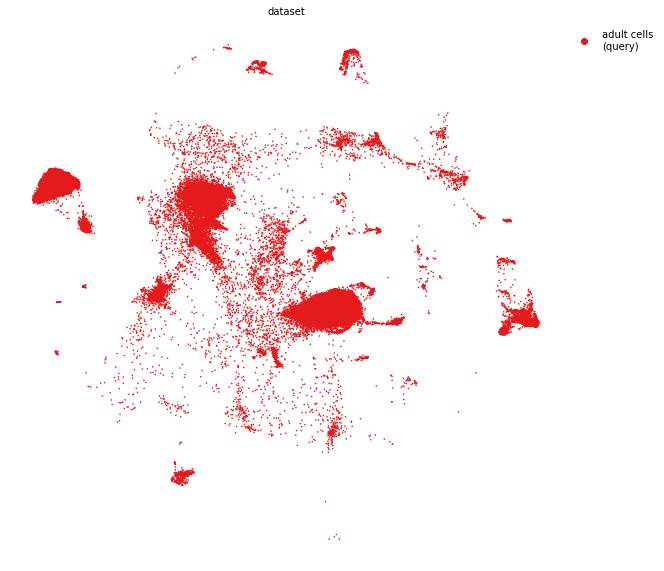

Trying to set attribute `.uns` of view, copying.


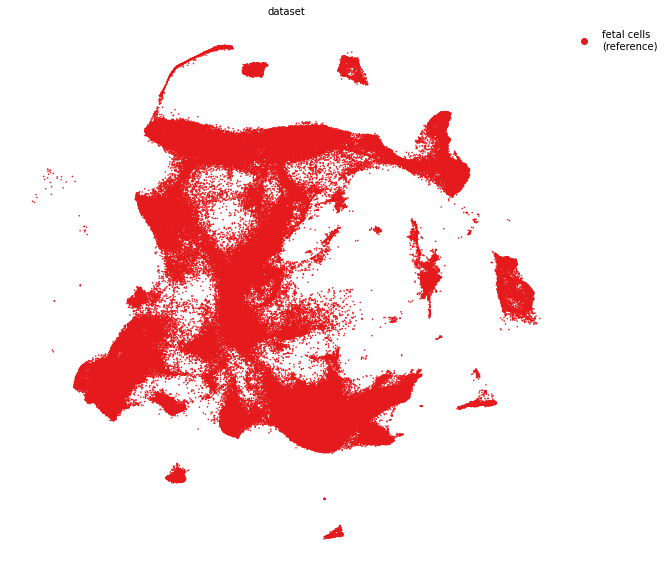

In [24]:
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'query'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'reference'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

In [25]:
merged_adata.obs["dataset"].value_counts()

reference    226688
query         54047
Name: dataset, dtype: int64

### Plot query and reference annotations

In [26]:
anno_labels_pl = {
#     'Tnaive/CM_CD4_activated':'Tnaive/CM_CD4',
#     'Tem/emra_CD8':'Trm/em_CD8',
#     'Trm_gut_CD8':'Trm/em_CD8',
#     'Tgd_CRTAM+':'Tgd',
#     'Trm_Tgd':'Tgd',
    'GC_B (I)':'GC B',
    'GC_B (II)':'GC B'
}

plt.rcParams['figure.figsize'] = [12,12]
merged_adata.obs["annotation_query_pl"] = [anno_labels_pl[x] if x in anno_labels_pl.keys() else x for x in merged_adata.obs["annotation_query"]]
label_counts = merged_adata.obs["annotation_query_pl"].value_counts()
anno_labels = label_counts.index[label_counts > 10]

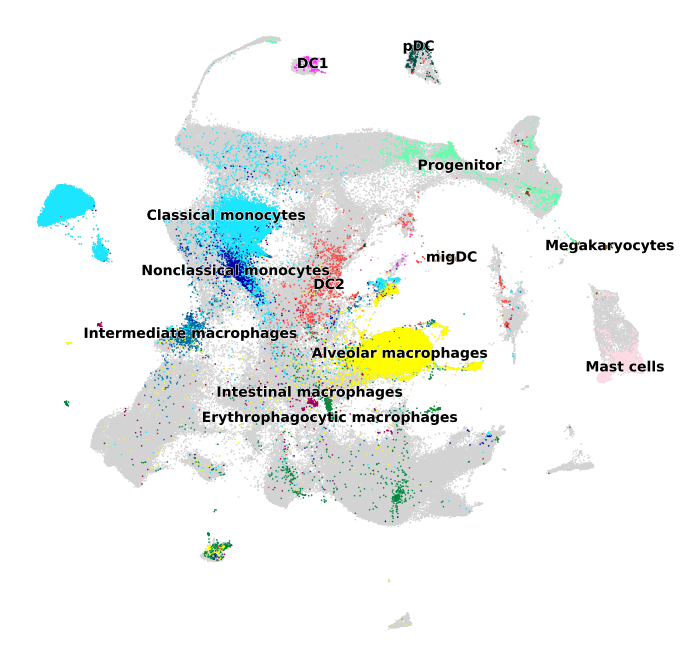

In [27]:
scv.pl.umap(merged_adata, color=["annotation_query_pl"], 
            size=10, 
            palette=sc.pl.palettes.godsnot_102,
            legend_loc="on data", groups=anno_labels, title="", 
            legend_fontsize=14, 
#             save="anno_query.png"
           )

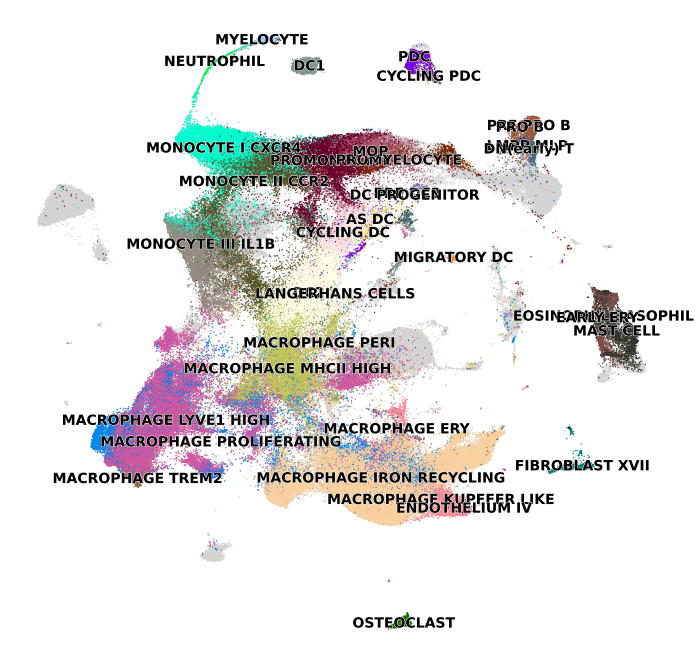

In [29]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["PROGENITORS"]]
anno_labels = [x for x in anno_labels if sum(merged_adata.obs['annotation_reference'] == x) > 30]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=14,
            title="",
#            save="anno_reference.png"
           )

In [31]:
sc.pp.normalize_total(merged_adata, target_sum=10e4)
sc.pp.log1p(merged_adata)

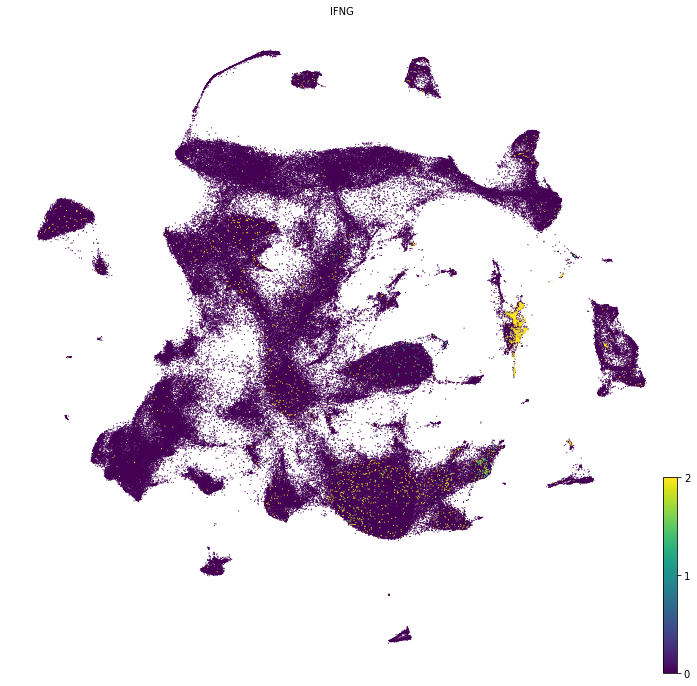

In [40]:
scv.pl.umap(merged_adata, color=['ENSG00000111537'], size=5, 
            legend_loc="on data",title=["IFNG"], ncols=2, vmax=2
           )

### Transfer labels

In [41]:
def predict_label2(merged_adata, anno_col = 'annotation_reference', k=50, min_score = 0.5):
    '''
    Predict annotation labels for query cells based on k-NNs in the reference data
    '''
    import time
    from scipy.spatial import cKDTree

    ## Extract embedding
    X_emb = merged_adata.obsm["X_scvi"].copy()

    is_query = merged_adata.obs["dataset"] == "query"
    is_reference = merged_adata.obs["dataset"] == "reference"

    X_emb_ref = X_emb[is_reference,:]
    X_emb_que = X_emb[is_query,:]

    ## Find nearest neighbors in reference
    k1=k2=k
    data_query = X_emb_que
    data_ref = X_emb_ref
    start = time.time()
    k_index_ref = cKDTree(data_ref).query(x=data_query, k=k1, n_jobs=5)[1]
    end = time.time()
    print(end - start)

    knn_mat = np.zeros(shape=[sum(is_query),sum(is_reference)])
    for i in range(k_index_ref.shape[0]):
        knn_mat[i, k_index_ref[i]] = 1

    ## Subset to reference cells that have are NN to at least one query cell
    keep_ref_ixs = np.unique(k_index_ref.ravel())
    keep_ref_ixs.sort()
    small_knn_mat = knn_mat[:,keep_ref_ixs]

    ## Make dummy matrix of annotations
    annos = merged_adata[is_reference].obs[anno_col][keep_ref_ixs].copy()
    dummy_df = pd.get_dummies(annos)
    dummy_mat = dummy_df.values

    ## Sum number of neighbors with each annotation
    new_anno = small_knn_mat.dot(dummy_mat)

    ## Find top scorers
    n_neighbors = np.array(small_knn_mat.sum(1)).flatten()
    n_neighbors_ref = new_anno.sum(axis=1)
    new_anno_prob = new_anno.T/n_neighbors_ref
    new_anno_prob[np.isnan(new_anno_prob)] = 0
    best_label = dummy_df.columns[new_anno_prob.argmax(0)].values
    best_label_score = new_anno_prob.max(0)
    best_label = best_label.astype('str')

    ## Call low confidence if probability is < min_score
    best_label_all = best_label.copy()
    best_label[best_label_score <= min_score] = "low_confidence"

    ## Save output in place
    del merged_adata.obs['predicted_anno'] 
    merged_adata.obs['predicted_anno'] = np.nan
    merged_adata.obs['predicted_anno_unfiltered'] = np.nan
    merged_adata.obs['predicted_anno_prob'] = np.nan
    merged_adata.obs.loc[is_query,'predicted_anno'] = best_label
    merged_adata.obs.loc[is_query,'predicted_anno_unfiltered'] = best_label_all
    merged_adata.obs.loc[is_query,'predicted_anno_prob'] = best_label_score

In [97]:
smp_merged_adata = sc.pp.subsample(merged_adata, fraction=0.5, copy=True)

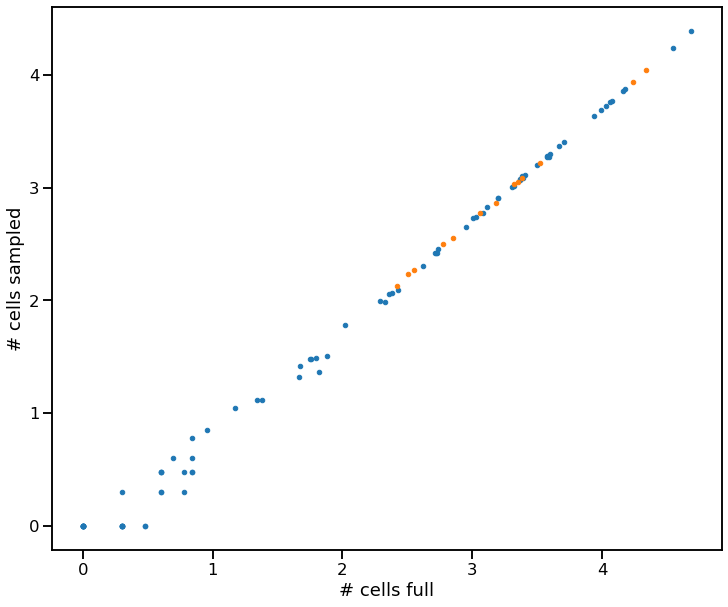

In [98]:
## Check cell numbers 
df = pd.concat([smp_merged_adata.obs.groupby('annotation_reference').size(), merged_adata.obs.groupby('annotation_reference').size()], 1)
plt.plot(np.log10(df[1]), np.log10(df[0]), '.', label='reference anno');
df = pd.concat([smp_merged_adata.obs.groupby('annotation_query').size(), merged_adata.obs.groupby('annotation_query').size()], 1)
sns.set_context('talk')
plt.plot(np.log10(df[1]), np.log10(df[0]), '.', label='query anno');
plt.xlabel('# cells full');plt.ylabel('# cells sampled');

In [99]:
smp_merged_adata.obs["annotation_reference"] = smp_merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
if 'predicted_anno' in smp_merged_adata.obs.columns:
    smp_merged_adata.obs.drop('predicted_anno', 1, inplace=True)
map_query_utils.predict_label2(smp_merged_adata, anno_col="annotation_reference")

13.328613519668579


In [154]:
smp_merged_adata.obs['predicted_anno'] = smp_merged_adata.obs['predicted_anno'].astype('str')
smp_merged_adata.obs['predicted_anno_unfiltered'] = smp_merged_adata.obs['predicted_anno_unfiltered'].astype('str')
smp_merged_adata.obs.loc[smp_merged_adata.obs['predicted_anno_prob'] < 0.5, 'predicted_anno'] = 'low_confidence'
smp_merged_adata.obs.loc[smp_merged_adata.obs['predicted_anno_prob'] >= 0.5, 'predicted_anno'] = smp_merged_adata.obs.loc[smp_merged_adata.obs['predicted_anno_prob'] > 0.3, 'predicted_anno_unfiltered']

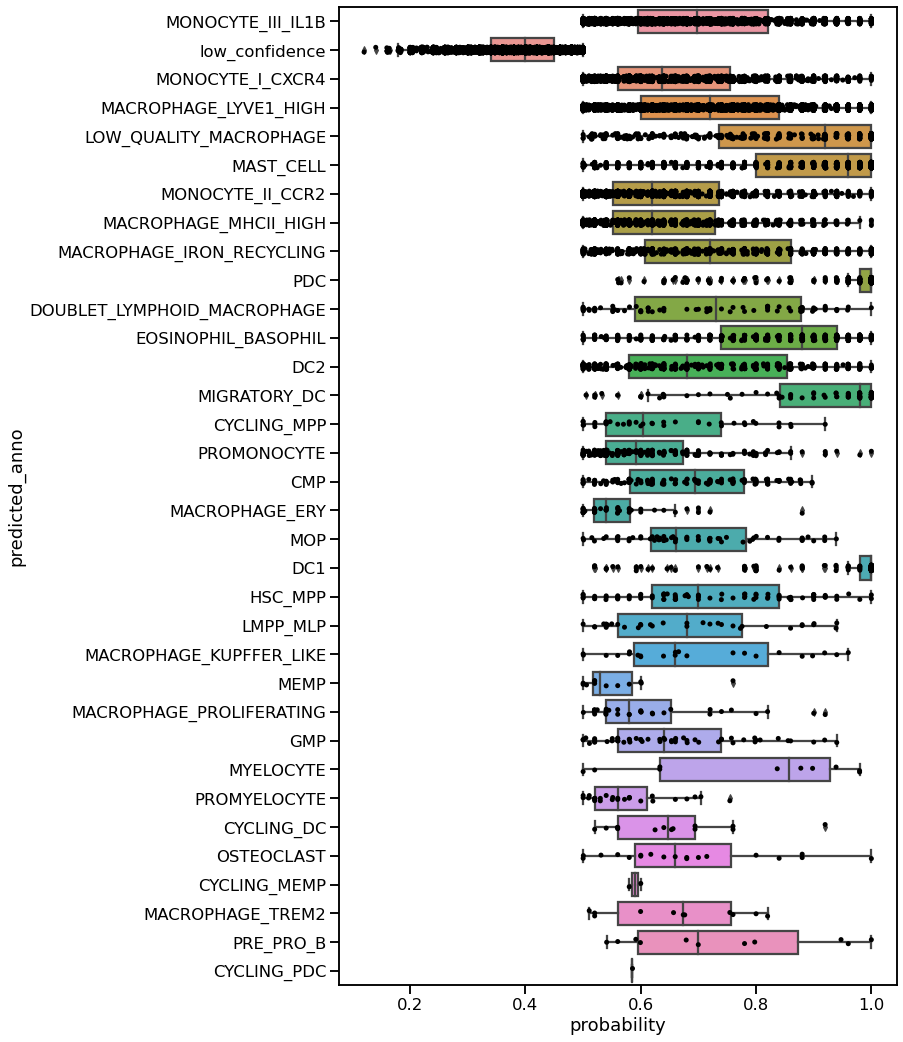

In [155]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(smp_merged_adata)

In [156]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = smp_merged_adata.obs_names[smp_merged_adata.obs.dataset == "query"]
empty_query = query_obs[smp_merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = smp_merged_adata[~smp_merged_adata.obs_names.isin(empty_query)].copy()
merged_adata_clean.obs[query_anno_col] = merged_adata_clean.obs[query_anno_col].astype("str")

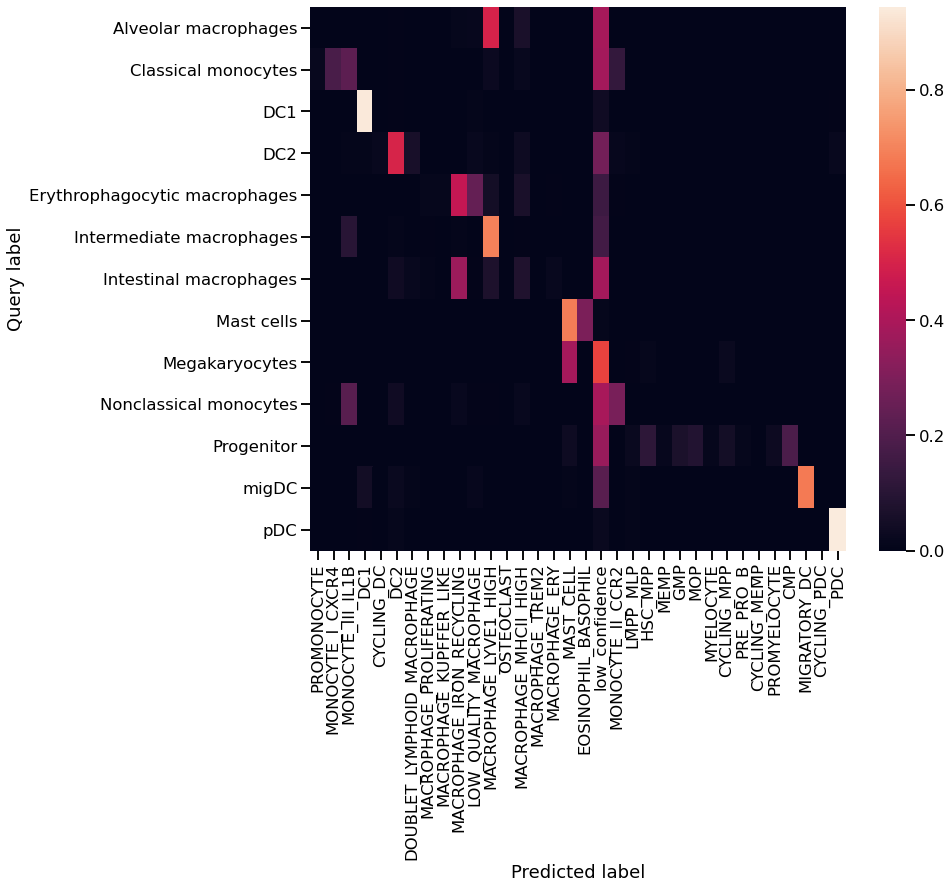

In [157]:
plt.rcParams["figure.figsize"] = [12,10]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

### Quantify matching between datasets

In [103]:
## Calculate distance of a query cell to closest cell of 
# predicted annotation

def _compute_min_dist2predicted_anno(merged_adata, r_cl,
#                                      q_cell,
                                     r_obs = 'annotation_reference',
                                     pred_anno_obs = 'predicted_anno_unfiltered'
                                    ):
    from scipy.spatial import cKDTree
    # Pick reference cluster 
    keep_ref_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)
    keep_query_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[pred_anno_obs] == r_cl)

    ## Calculate distance of query cell to all reference
    # cells in cluster
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_ref_cells,:]
    X_dims_invitro = X_dims[keep_query_cells,:]
    k_ref = cKDTree(X_dims_invivo).query(x=X_dims_invitro, k=1, n_jobs=5)
    min_dists = k_ref[0]
    min_dists_df = pd.DataFrame(zip(merged_adata.obs_names[keep_query_cells],min_dists), columns=['query_cell', 'min_distance2pred'])
    return(min_dists_df)

start = time.time()
smp_merged_adata.obs['min_distance2pred'] = np.nan
counter = 0
is_query = smp_merged_adata.obs["dataset"] == "query"
is_reference = smp_merged_adata.obs["dataset"] == "reference"
for r_cl in smp_merged_adata.obs['predicted_anno_unfiltered'].unique():
    counter += 1
    min_dists_df = _compute_min_dist2predicted_anno(smp_merged_adata, r_cl)
    smp_merged_adata.obs.loc[min_dists_df.query_cell, 'min_distance2pred'] = min_dists_df.min_distance2pred.values
    print(counter)
## Normalize w gaussian kernel
smp_merged_adata.obs.loc[is_query, 'min_distance2pred'] = map_query_utils._scArches_adjusted_dist(smp_merged_adata.obs.loc[is_query, 'min_distance2pred'].astype('float').values)
end = time.time()
print(end-start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
2.1041789054870605


### Combined similarity & confusion matrix

In [158]:
q_df = smp_merged_adata[smp_merged_adata.obs['dataset'] == 'query'].obs[["min_distance2pred", "predicted_anno", "annotation_query", 'organ_code']]
q_df = q_df[~q_df.annotation_query.isna()]
q_df.annotation_query = q_df.annotation_query.astype('str')
q_df.min_distance2pred = q_df.min_distance2pred.astype('float')

In [159]:
query_anno_group_myeloid = {
    "MACs":[x for x in q_df.annotation_query.unique() if "acrophage" in x] + ["Kupffer cells"],
    'DCs':[x for x in q_df.annotation_query.unique() if "DC" in x],
    "Mono":[x for x in q_df.annotation_query.unique() if "mono" in x],
    }

query_anno_group_myeloid['other'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_myeloid.values(),[])]
query_anno_group_myeloid_rev = {x:g for g,a in query_anno_group_myeloid.items() for x in a}

ref_anno_group_myeloid = {
    "MACs":[x for x in q_df.predicted_anno.unique() if "ACROPHAGE" in x],
    'DCs':[x for x in q_df.predicted_anno.unique() if "DC" in x],
    "Mono":[x for x in q_df.predicted_anno.unique() if "MONO" in x],
    'low_confidence':['low_confidence']
    }

ref_anno_group_myeloid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_myeloid.values(),[])]
ref_anno_group_myeloid_rev = {x:g for g,a in ref_anno_group_myeloid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_myeloid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_myeloid_rev[x] for x in q_df['predicted_anno']]

In [160]:
q_df

min_distance2pred  \
CZI-IA10471911+CZI-IA10472007_GGTGTTAAGCACACAG-...           0.698631   
CZINY-0107_TTCACGCCACGGTGAA-query                            0.636232   
CZINY-0061_ATCGTCCAGACCCGCT-query                            0.665870   
CZINY-0049_GTGGGAAGTCCGGATC-query                            0.664473   
CZINY-0064_CTCTCGAGTACCGTCG-query                            0.604129   
...                                                               ...   
Pan_T7980367_CCCAGTTCACAAGACG-query                          0.728904   
Pan_T8986829_CTCTGGTTCGAGAGCA-query                          0.660113   
CZINY-0104_GGTTGTAAGGCCACCT-query                            0.609775   
CZINY-0099_GTCGCGAGTCATCCCT-query                            0.618916   
Pan_T7991591_AAACGGGCAGGCTCAC-query                          0.663270   

                                                           predicted_anno  \
CZI-IA10471911+CZI-IA10472007_GGTGTTAAGCACACAG-...      MONOCYTE_III_IL1B   
CZINY-0107_TTCACGCCACGGTGAA-query                          low_confidence   
CZINY-0061_ATCGTCCAGACCCGCT-query                        MONOCYTE_I_CXCR4   
CZINY-0049_GTGGGAAGTCCGGATC-query                        MONOCYTE_I_CXCR4   
CZINY-0064_CTCTCGAGTACCGTCG-query                        MONOCYTE_I_CXCR4   
...                                                                   ...   
Pan_T7980367_CCCAGTTCACAAGACG-query                 MACROPHAGE_LYVE1_HIGH   
Pan_T8986829_CTCTGGTTCGAGAGCA-query                        low_confidence   
CZINY-0104_GGTTGTAAGGCCACCT-query                   MACROPHAGE_LYVE1_HIGH   
CZINY-0099_GTCGCGAGTCATCCCT-query                   MACROPHAGE_LYVE1_HIGH   
Pan_T7991591_AAACGGGCAGGCTCAC-query                      MONOCYTE_II_CCR2   

                                                          annotation_query  \
CZI-IA10471911+CZI-IA10472007_GGTGTTAAGCACACAG-...     Classical monocytes   
CZINY-0107_TTCACGCCACGGTGAA-query                     Alveolar macrophages   
CZINY-0061_ATCGTCCAGACCCGCT-query                      Classical monocytes   
CZINY-0049_GTGGGAAGTCCGGATC-query                      Classical monocytes   
CZINY-0064_CTCTCGAGTACCGTCG-query                      Classical monocytes   
...                                                                    ...   
Pan_T7980367_CCCAGTTCACAAGACG-query                   Alveolar macrophages   
Pan_T8986829_CTCTGGTTCGAGAGCA-query                 Nonclassical monocytes   
CZINY-0104_GGTTGTAAGGCCACCT-query                     Alveolar macrophages   
CZINY-0099_GTCGCGAGTCATCCCT-query                     Alveolar macrophages   
Pan_T7991591_AAACGGGCAGGCTCAC-query                    Classical monocytes   

                                                   organ_code  \
CZI-IA10471911+CZI-IA10472007_GGTGTTAAGCACACAG-...        LIV   
CZINY-0107_TTCACGCCACGGTGAA-query                         LNG   
CZINY-0061_ATCGTCCAGACCCGCT-query                         BLD   
CZINY-0049_GTGGGAAGTCCGGATC-query                         BLD   
CZINY-0064_CTCTCGAGTACCGTCG-query                         BMA   
...                                                       ...   
Pan_T7980367_CCCAGTTCACAAGACG-query                       LNG   
Pan_T8986829_CTCTGGTTCGAGAGCA-query                       LIV   
CZINY-0104_GGTTGTAAGGCCACCT-query                         LNG   
CZINY-0099_GTCGCGAGTCATCCCT-query                         LNG   
Pan_T7991591_AAACGGGCAGGCTCAC-query                       SPL   

                                                   annotation_query_group  \
CZI-IA10471911+CZI-IA10472007_GGTGTTAAGCACACAG-...                   Mono   
CZINY-0107_TTCACGCCACGGTGAA-query                                    MACs   
CZINY-0061_ATCGTCCAGACCCGCT-query                                    Mono   
CZINY-0049_GTGGGAAGTCCGGATC-query                                    Mono   
CZINY-0064_CTCTCGAGTACCGTCG-query                                    Mono   
...                                                                   

In [161]:
%%R -i q_df
head(q_df)

                                                     min_distance2pred
CZI-IA10471911+CZI-IA10472007_GGTGTTAAGCACACAG-query         0.6986312
CZINY-0107_TTCACGCCACGGTGAA-query                            0.6362322
CZINY-0061_ATCGTCCAGACCCGCT-query                            0.6658704
CZINY-0049_GTGGGAAGTCCGGATC-query                            0.6644729
CZINY-0064_CTCTCGAGTACCGTCG-query                            0.6041289
CZI-IA10471910+CZI-IA10472006_CATGGCGCATGTCTCC-query         0.5367936
                                                        predicted_anno
CZI-IA10471911+CZI-IA10472007_GGTGTTAAGCACACAG-query MONOCYTE_III_IL1B
CZINY-0107_TTCACGCCACGGTGAA-query                       low_confidence
CZINY-0061_ATCGTCCAGACCCGCT-query                     MONOCYTE_I_CXCR4
CZINY-0049_GTGGGAAGTCCGGATC-query                     MONOCYTE_I_CXCR4
CZINY-0064_CTCTCGAGTACCGTCG-query                     MONOCYTE_I_CXCR4
CZI-IA10471910+CZI-IA10472006_CATGGCGCATGTCTCC-query    low_confidence
      

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


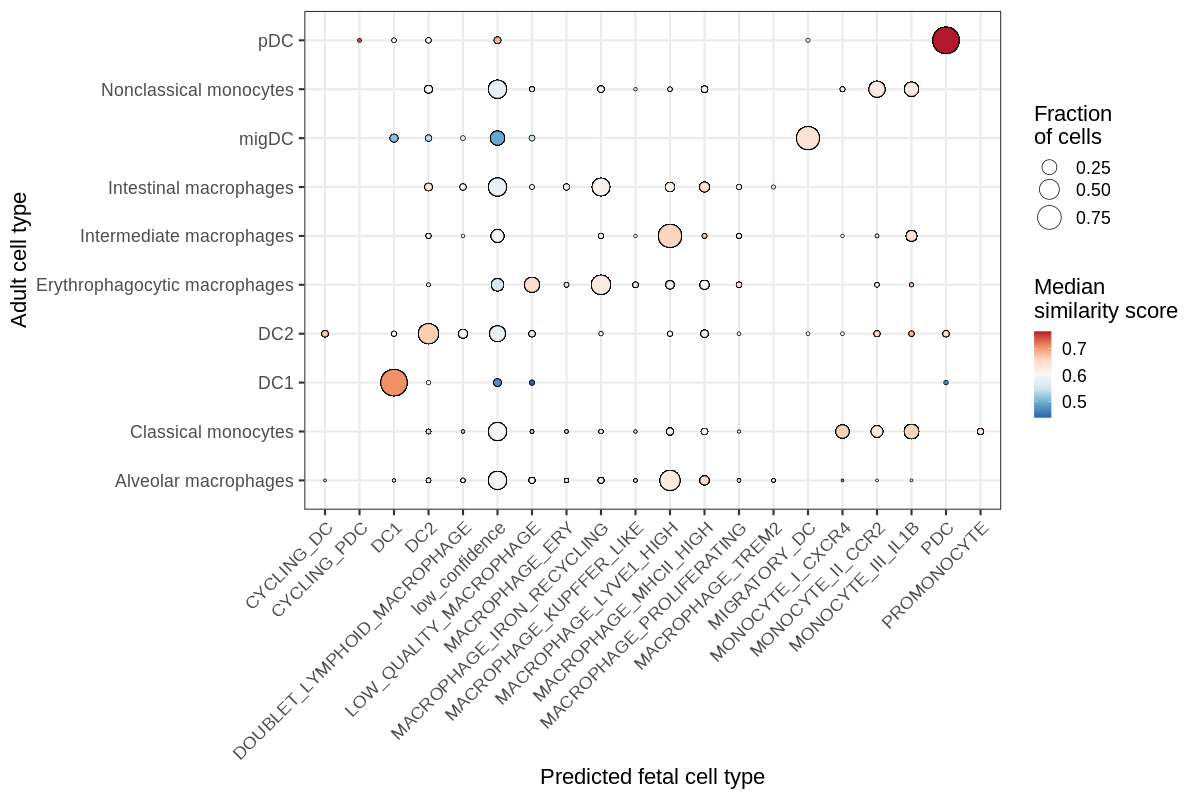

In [162]:
%%R -h 800 -w 1200 
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(min_distance2pred)) %>%
    ungroup() %>%
    filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=c('DCs', 'Mono', 'MACs'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('DCs', 'Mono', 'MACs', ''))) %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_size(range=c(1,12), name="Fraction\nof cells") +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
#     facet_grid(annotation_query_group~as.factor(predicted_anno_group), space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) 
#     ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=15, height=10)

In [53]:
## Save for future plotting
q_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_MYELOID_query.mapped2MYELOID_V2.confusion_table.csv')

In [174]:
q_df = smp_merged_adata[smp_merged_adata.obs['dataset'] == 'query'].obs[["min_distance2pred", "predicted_anno_unfiltered", "annotation_query", 'organ_code', "predicted_anno_prob"]]
q_df = q_df[~q_df.annotation_query.isna()]
q_df.annotation_query = q_df.annotation_query.astype('str')
q_df.min_distance2pred = q_df.min_distance2pred.astype('float')

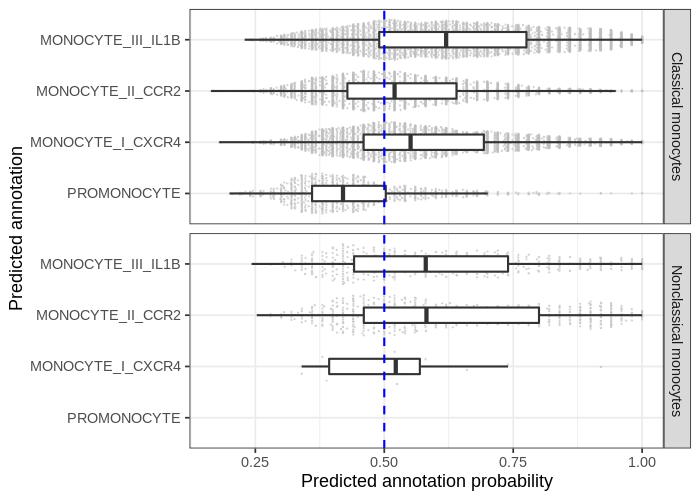

In [214]:
%%R -i q_df -h 500 -w 700
q_df %>%
    filter(str_detect(annotation_query, 'monocytes')) %>%
    filter(str_detect(predicted_anno_unfiltered, 'MONOCYTE')) %>%
    mutate(predicted_anno_unfiltered = factor(predicted_anno_unfiltered, c("PROMONOCYTE", "MONOCYTE_I_CXCR4", "MONOCYTE_II_CCR2", "MONOCYTE_III_IL1B"))) %>%
    ggplot(aes(predicted_anno_unfiltered, predicted_anno_prob)) +
#     geom_violin(scale='width') +
    ggbeeswarm::geom_quasirandom(size=0.5, alpha=0.5, color='grey') +
    geom_boxplot(width=0.3, outlier.alpha=0, size=1) +
    facet_grid(annotation_query~.) +
    coord_flip() +
    geom_hline(yintercept=0.5, linetype=2, color='blue', size=1) +
    theme_bw(base_size=18) +
    xlab("Predicted annotation") + ylab("Predicted annotation probability")

In [195]:
for monos in ['MONOCYTE_I_CXCR4', 'MONOCYTE_II_CCR2', 'MONOCYTE_III_IL1B']:
    q_df[q_df['predicted_anno'] == monos].value_counts("organ_code")

KeyError: 'predicted_anno'

In [56]:
q_df_monos = q_df[q_df['annotation_query'].isin(['MONOCYTE_I_CXCR4', 'MONOCYTE_II_CCR2', 'MONOCYTE_III_IL1B'])]
monos_organ = q_df_monos.groupby(['predicted_anno','organ_code'] ).size().reset_index()

In [194]:
monos_organ

Empty DataFrame
Columns: [predicted_anno, organ_code, 0]
Index: []

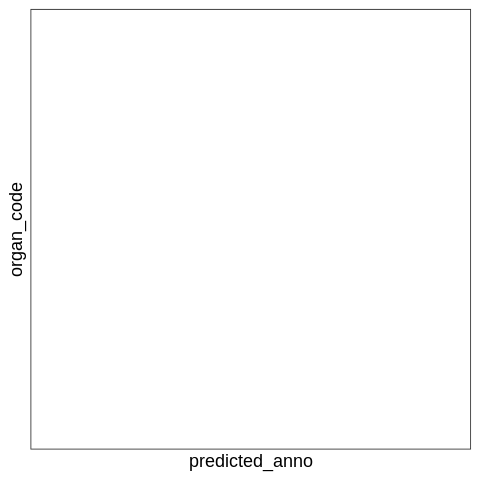

In [59]:
%%R -i monos_organ -i figdir
monos_organ %>%
    rename(n_cells=`0`) %>%
    ggplot(aes(predicted_anno,`organ_code`, fill= n_cells)) +
    geom_tile() +
    geom_text(aes(label=n_cells)) +
    scale_fill_distiller(palette="Reds", direction=1) +
    theme_bw(base_size=18) +
    theme(axis.text.x=element_text(angle=90)) +
    ggsave(paste0(figdir, 'predicted_monocytes_organ_distribution.pdf'), width=7, height=8)

In [148]:
smp_merged_adata.var_names = smp_merged_adata.var.GeneName.values.copy()

In [153]:
merged_adata.var_names = merged_adata.var_names.astype("str")

In [154]:
merged_adata.var_names_make_unique()

In [158]:
sc.pp.normalize_total(merged_adata, target_sum=10e4)
sc.pp.log1p(merged_adata)

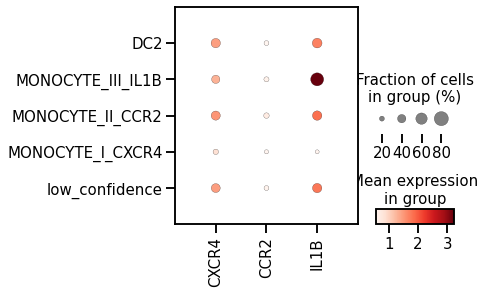

In [199]:

sc.pl.dotplot(merged_adata[q_df_monos.index],['CXCR4', "CCR2", "IL1B"] ,groupby='predicted_anno', 
                    figsize=[5, 4], save='mono_adult.pdf')
# fig.savefig(figdir+'dotplot_mono_adult.pdf',bbox='tight')

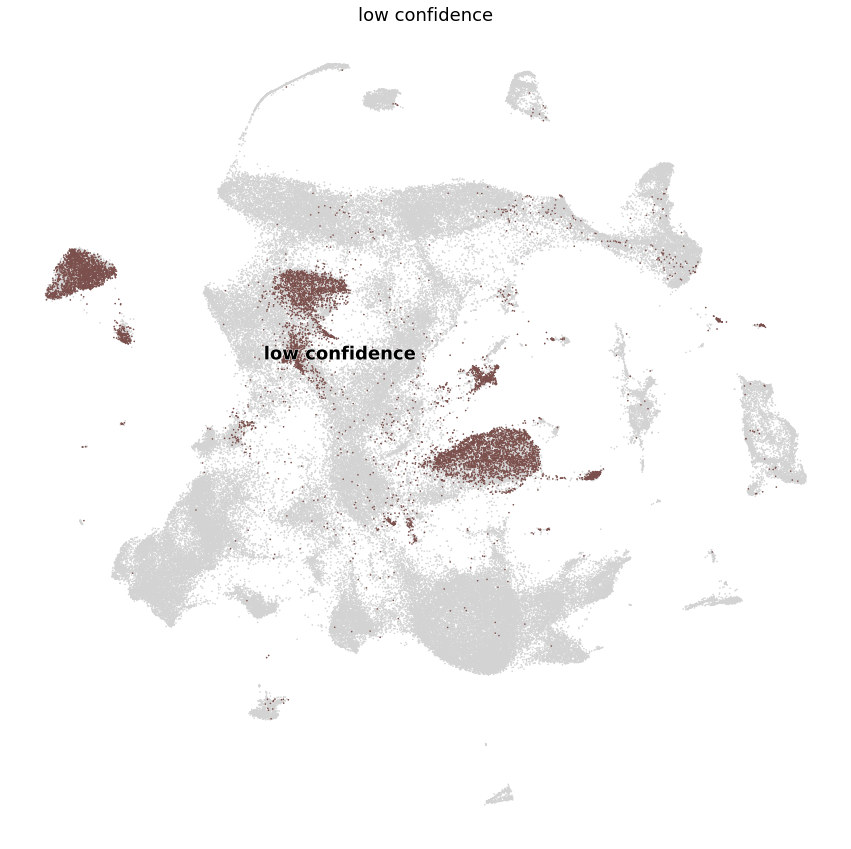

In [110]:
plt.rcParams['figure.figsize'] = [15,15]
scv.pl.umap(smp_merged_adata, color='predicted_anno', size=10, groups=['low_confidence'])

In [217]:
merged_adata.obs[merged_adata.obs['annotation_query'].isin(["Erythrophagocytic macrophages"])].value_counts('organ code')

organ code
SPL    705
LIV    389
MLN     86
TLN     58
DUO     37
BMA     27
LNG     17
ILE     17
OME     14
SKM      4
TCL      3
CAE      3
SCL      2
nan      0
THY      0
BLD      0
dtype: int64

### Save outputs

In [38]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

In [7]:
merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

#### Updated query annotation from Cecilia/Chuan  

In [8]:
pi_adata_new = sc.read_h5ad('/nfs/team205/cx1/Celltypist/revision_science/data/PIP_global_object_raw_count.h5ad')

In [9]:
query_obs = merged_adata.obs_names[merged_adata.obs['dataset'] == 'query'].str.strip('-query')
query_obs = query_obs[query_obs.isin(pi_adata_new.obs_names)]
new_annos = pi_adata_new[query_obs].obs['Category'].values

merged_adata.obs['annotation_query'] = np.nan
merged_adata.obs.loc[query_obs+'-query','annotation_query'] = new_annos

In [13]:
# ## Reverse UMAP coords
# merged_adata.obsm["X_umap_rev"] = merged_adata.obsm["X_umap"].copy()
# merged_adata.obsm["X_umap"][:,1] = - merged_adata.obsm["X_umap"][:,1]

## Mapping validation metrics

In [84]:
query_mapped_adata = merged_adata[merged_adata.obs['dataset'] == 'query'].copy()

sc.pp.neighbors(query_mapped_adata, use_rep='X_scvi', n_neighbors=30)

In [111]:
sc.tl.leiden(query_mapped_adata, resolution=0.5)

In [112]:
query_mapped_adata.obs['leiden'] = query_mapped_adata.obs['leiden'].astype("str")
query_mapped_adata.obs['annotation_query'] = query_mapped_adata.obs['annotation_query'].astype("str")

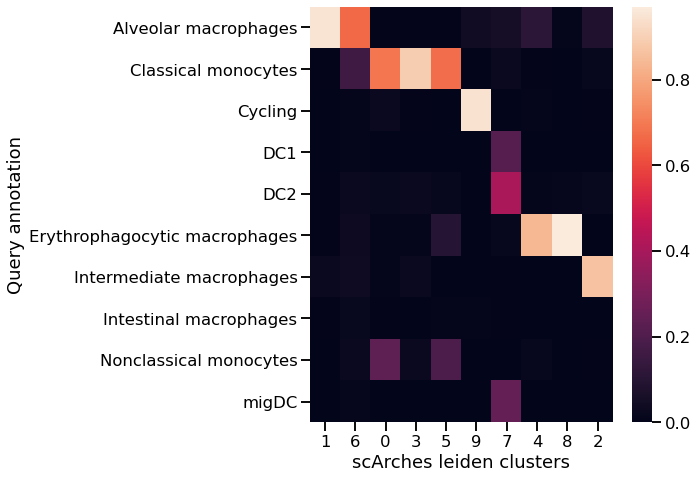

In [114]:
sns.set_context("talk")
keep_cts = query_mapped_adata.obs['annotation_query'].value_counts().index[query_mapped_adata.obs['annotation_query'].value_counts() > 10]
keep_cts = keep_cts[keep_cts!='nan']
conf_mat = sc.metrics.confusion_matrix('leiden','annotation_query', 
                                       query_mapped_adata.obs[query_mapped_adata.obs['annotation_query'].isin(keep_cts)]).T

col_order = conf_mat.idxmax(0).sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal

plt.rcParams['figure.figsize'] = [10, 7]
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True);
plt.xlabel("scArches leiden clusters");
plt.ylabel("Query annotation");
plt.tight_layout();
plt.savefig(figdir + 'validation_conf_mat.pdf')

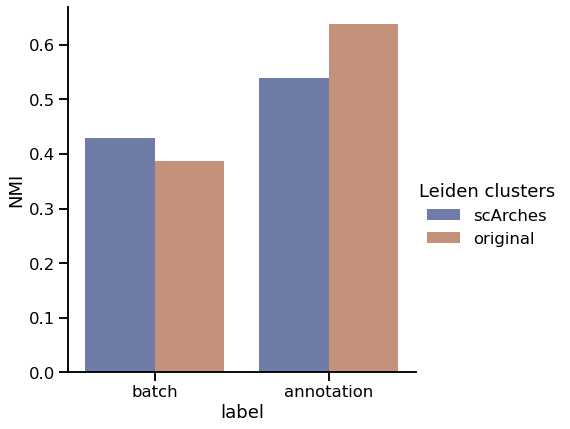

In [116]:
import sklearn
nmi_anno_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden5"])
nmi_anno_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden"])
nmi_batch_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden5"])
nmi_batch_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden"])

df = pd.DataFrame([nmi_batch_new, nmi_batch_old,nmi_anno_new, nmi_anno_old])
df.columns = ['NMI']
df['cat'] = ['batch_scArches', 'batch_original', 'annotation_scArches', "annotation_original"]
df['Leiden clusters'] = [x[1] for x in df['cat'].str.split("_")]
df['label'] = [x[0] for x in df['cat'].str.split("_")]

sns.catplot(
    data=df, kind="bar",
    x="label", y="NMI", hue='Leiden clusters',
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.savefig(figdir + 'validation_barplot.pdf')

---

### Plot similarity by organ

In [ ]:
df = merged_adata.obs[["annotation_reference", "organ", "age", "mnn_sim_ratio", "annotation_query", "organ code"]]

In [101]:
exclude_labels = anno_groups_dict["OTHER"]

In [21]:
%%R -i df
head(df)

                                          annotation_reference organ age
FCAImmP7579224-ATTACTCTCGATGAGG-reference                  DC3    SK  12
FCAImmP7579224-TGCTACCTCATGTAGC-reference                  DC3    SK  12
FCAImmP7579224-ACGGCCACAAGCTGAG-reference                  DC2    SK  12
FCAImmP7579224-ATTATCCAGGTTACCT-reference                  DC3    SK  12
FCAImmP7579224-GGAGCAACAATGGACG-reference                  DC1    SK  12
FCAImmP7579224-ATCACGATCACGATGT-reference                  DC3    SK  12
                                          mnn_sim_ratio annotation_query
FCAImmP7579224-ATTACTCTCGATGAGG-reference     0.0000000              nan
FCAImmP7579224-TGCTACCTCATGTAGC-reference     0.0000000              nan
FCAImmP7579224-ACGGCCACAAGCTGAG-reference     0.5987848              nan
FCAImmP7579224-ATTATCCAGGTTACCT-reference     0.0000000              nan
FCAImmP7579224-GGAGCAACAATGGACG-reference     0.0000000              nan
FCAImmP7579224-ATCACGATCACGATGT-reference     0.000

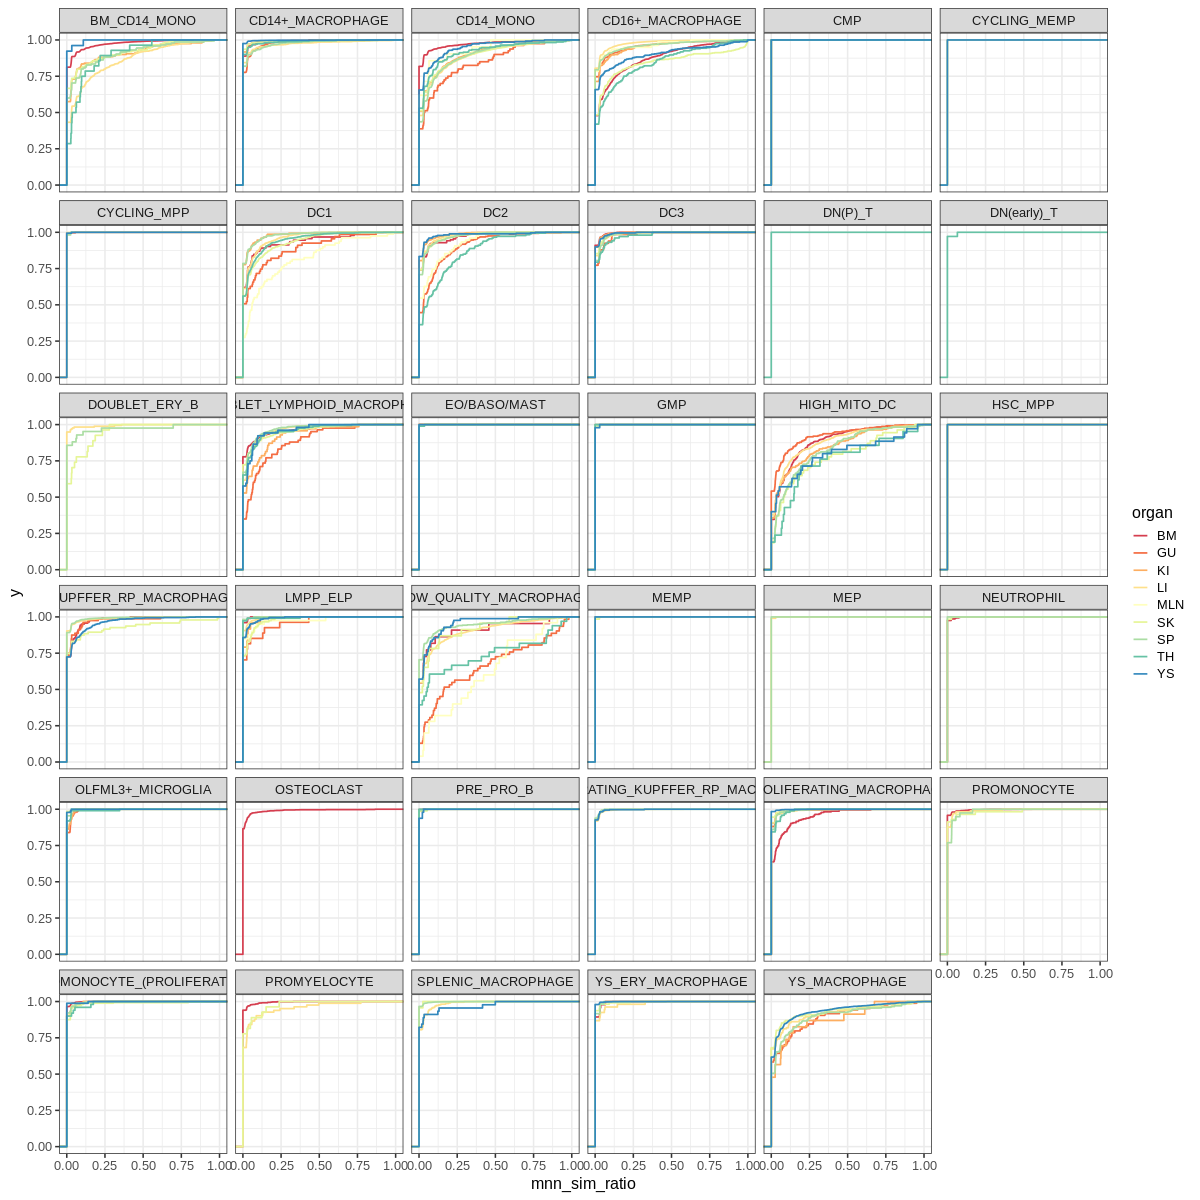

In [115]:
%%R -w 1200 -h 1200
df %>%
    filter(!is.na(organ)) %>%
    group_by(annotation_reference, organ) %>%
    filter(n() > 20) %>%
    ggplot(aes(mnn_sim_ratio, color=organ)) +
    stat_ecdf(size=0.8) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_reference~.) +
    scale_color_brewer(palette = "Spectral")

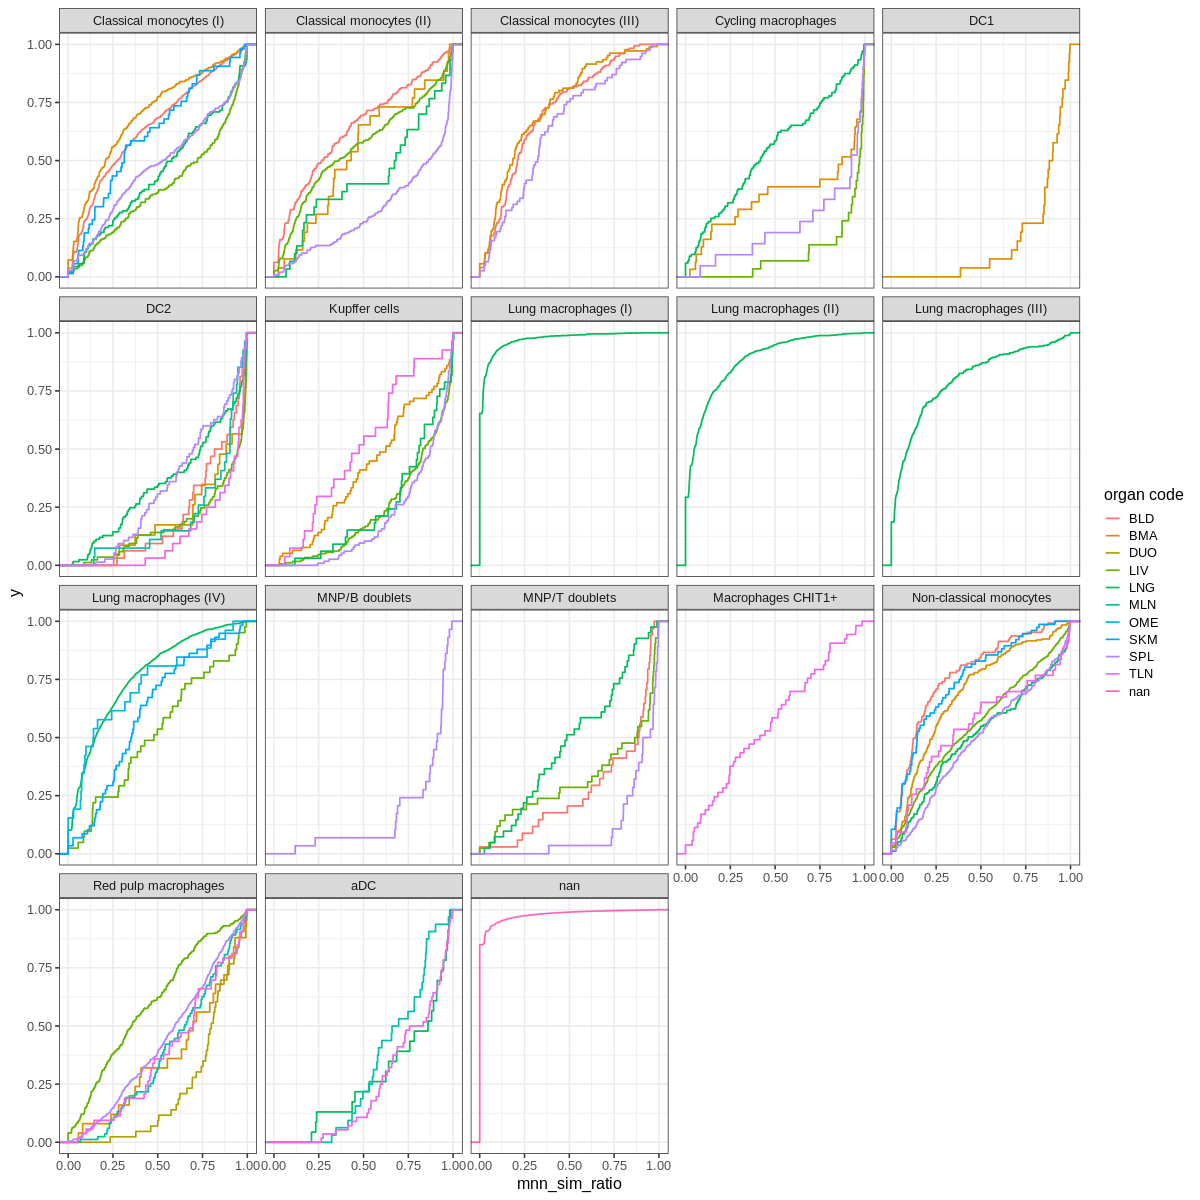

In [116]:
%%R -w 1200 -h 1200
df %>%
    filter(!is.na(`organ code`)) %>%
    group_by(annotation_query, `organ code`) %>%
    filter(n() > 20) %>%
    ggplot(aes(mnn_sim_ratio, color=`organ code`)) +
    stat_ecdf(size=0.8) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_query~.) 


In [50]:
%%R -w 1200 -h 800 -i figdir
df %>%
    filter(annotation_query!="nan") %>%
    filter(!is.na(`organ code`)) %>%
    group_by(annotation_query, `organ code`) %>%
    filter(n() > 20) %>%
    ggplot(aes(`organ code`,mnn_sim_ratio, fill=`organ code`)) +
    geom_violin(scale="width") +
    geom_point(data = . %>% group_by(annotation_query, `organ code`) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_query~.) +
    scale_fill_brewer(palette="Spectral") +
    ylab("Similarity score") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_query.pdf"), height=10, width=15)
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_query.png"), height=10, width=15)
    
#     scale_fill_viridis_c(option="magma")

`summarise()` has grouped output by 'annotation_query'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'annotation_query'. You can override using the `.groups` argument.


In [58]:
%%R -w 1200 -h 800 -i figdir
df %>%
#     filter(annotation_query=="nan") %>%
    filter(!is.na(organ)) %>%
    group_by(annotation_reference, organ) %>%
    filter(n() > 20) %>%
    ggplot(aes(organ,mnn_sim_ratio, fill=organ)) +
    geom_violin(scale="width") +
    geom_point(data = . %>% group_by(annotation_reference, organ) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_reference~.) +
    scale_fill_brewer(palette="Spectral") +
    ylab("Similarity score") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_reference.pdf"), height=10, width=15)
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_reference.png"), height=10, width=15)
    
#     scale_fill_viridis_c(option="magma")

`summarise()` has grouped output by 'annotation_reference'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'annotation_reference'. You can override using the `.groups` argument.


In [58]:
%%R -w 1200 -h 800 -i figdir
df %>%
#     filter(annotation_query=="nan") %>%
    filter(!is.na(organ)) %>%
    group_by(annotation_reference, organ) %>%
    filter(n() > 20) %>%
    ggplot(aes(organ,mnn_sim_ratio, fill=organ)) +
    geom_violin(scale="width") +
    geom_point(data = . %>% group_by(annotation_reference, organ) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_reference~.) +
    scale_fill_brewer(palette="Spectral") +
    ylab("Similarity score") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_reference.pdf"), height=10, width=15)
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_reference.png"), height=10, width=15)
    
#     scale_fill_viridis_c(option="magma")

`summarise()` has grouped output by 'annotation_reference'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'annotation_reference'. You can override using the `.groups` argument.


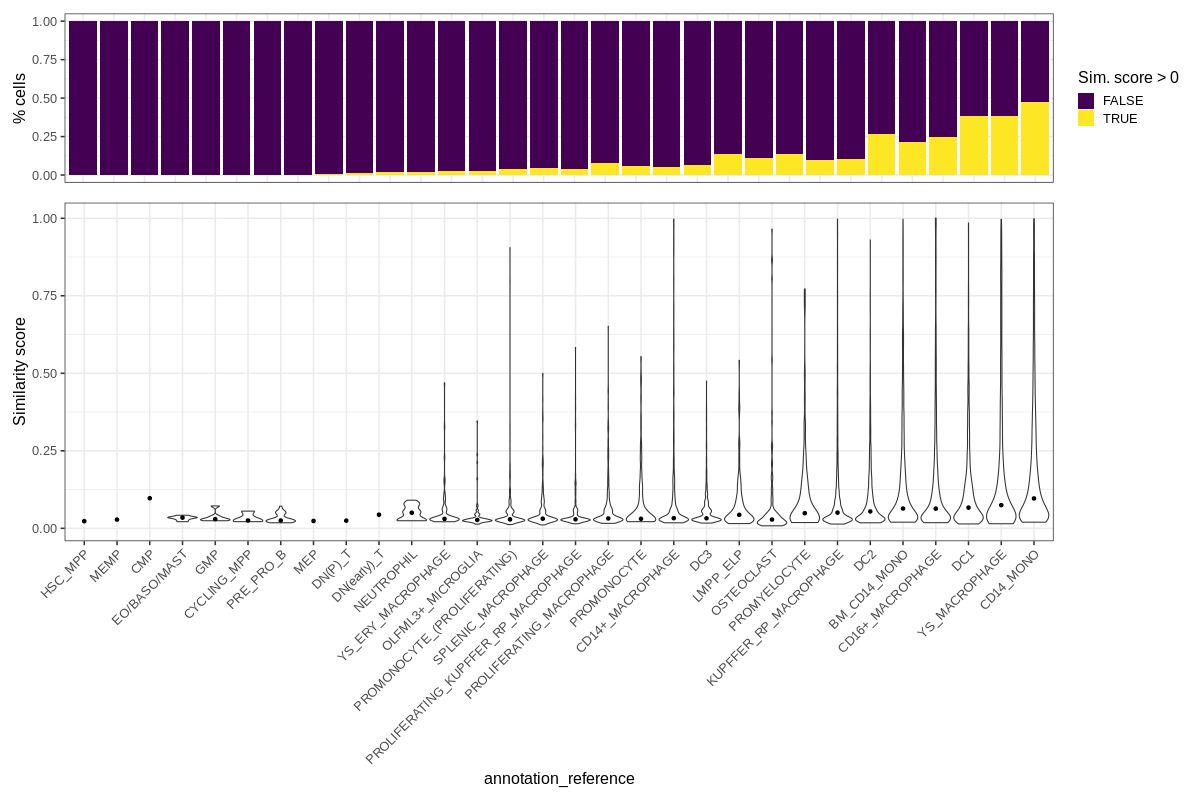

In [103]:
%%R -w 1200 -h 800 -i exclude_labels
top_bp <- df %>%
    filter(!is.na(organ)) %>%
    filter(!annotation_reference %in% exclude_labels) %>%
    group_by(annotation_reference) %>% 
    mutate(median=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    arrange(median) %>%
    mutate(annotation_reference=factor(annotation_reference, levels=unique(annotation_reference))) %>%
    mutate(sim_cuts = mnn_sim_ratio!=0) %>%
    ggplot(aes(annotation_reference, fill=sim_cuts)) +
    geom_bar(position="fill") +
    scale_fill_viridis_d(name="Sim. score > 0") +
#     geom_violin(scale="width") +
#     geom_point(data = . %>% group_by(annotation_reference) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
#     facet_wrap(annotation_reference~.) +
#     scale_fill_brewer(palette="Spectral") +
    ylab("% cells") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))

bottom_vp <- df %>%
    filter(!is.na(organ)) %>%
    filter(!annotation_reference %in% exclude_labels) %>%
    group_by(annotation_reference) %>% 
    mutate(median=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    arrange(median) %>%
    mutate(annotation_reference=factor(annotation_reference, levels=unique(annotation_reference))) %>%
    filter(mnn_sim_ratio > 0) %>%
    ggplot(aes(annotation_reference, mnn_sim_ratio)) +
    geom_violin(scale="width") +
#     geom_jitter(size=0.1) +
    geom_point(data = . %>% group_by(annotation_reference) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
#     facet_wrap(annotation_reference~.) +
#     scale_fill_brewer(palette="Spectral") +
    ylab("Similarity score") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))
    
((top_bp + remove_x_axis()) / bottom_vp) +
plot_layout(heights=c(1,2))

### Plot similarity scores on top of just fetal embedding

In [15]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID"

In [16]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))
adata.var_names_make_unique()

In [17]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])

adata = adata[~adata.obs_names.isin(mat_barcodes["x"])]

In [18]:
### Load annotations

anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

In [19]:
adata.obs_names = adata.obs_names + "-reference"

In [20]:
adata.obs["mnn_sim_ratio"] = merged_adata[adata.obs_names].obs["mnn_sim_ratio"]

... storing 'anno_lvl_2_final_clean' as categorical


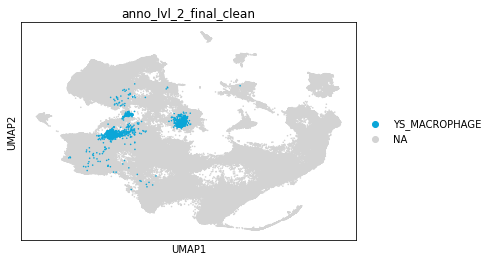

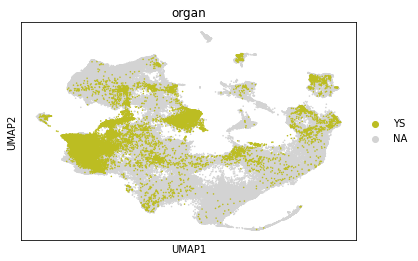

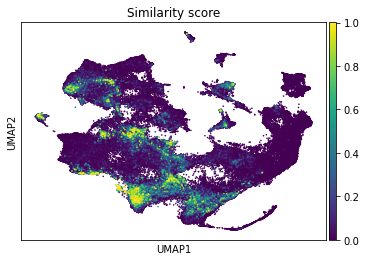

In [21]:
sc.pl.umap(adata, color="anno_lvl_2_final_clean", size=10, groups=["YS_MACROPHAGE"])
sc.pl.umap(adata, color="organ", size=10, groups=["YS"])
sc.pl.umap(adata, color="mnn_sim_ratio", size=10, title="Similarity score", save="similarity_score_justRef.png")

In [138]:
merged_adata.var_names = merged_adata.var['gene_names'].astype('str').copy()
merged_adata.var_names_make_unique()

In [140]:
sc.pp.normalize_total(merged_adata, target_sum=10e4)

In [141]:
sc.pp.log1p(merged_adata)

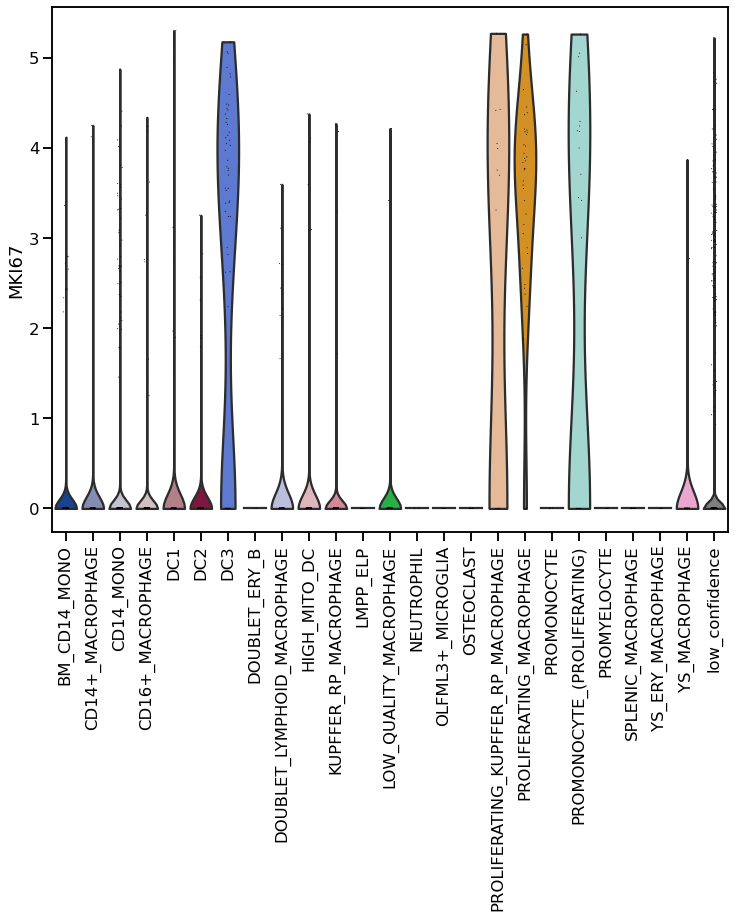

In [142]:
sc.pl.violin(merged_adata, "MKI67", groupby="predicted_anno", rotation=90)

### Visualize predicted identities for most similar cells

In [334]:
merged_adata.obs["dataset"] = ["reference" if x == "query" else 'query' for x in merged_adata.obs["dataset"]]
del merged_adata.obs["predicted_anno"]

In [341]:
anno_col="annotation_query"
neighbors_key="connectivities"
min_score=0
# min_ref_neighbors = adata.uns["neighbors"]["params"]["n_neighbors"]/10
min_ref_neighbors = 1
missing_anno = merged_adata.obs["dataset"] == "query"
w_anno = merged_adata.obs["dataset"] == "reference"

## Find neighbors of cells with conflicting annotation
knn_graph = merged_adata.obsp[neighbors_key]
knn_graph_query = knn_graph[missing_anno,:][:,w_anno]
knn_graph_query[knn_graph_query.nonzero()] = 1

In [342]:
## Find most abundant cell label in neighbors
neighbors_labels = pd.DataFrame()
n_neighbors_labels = pd.DataFrame()

annos = merged_adata.obs.loc[w_anno,anno_col].copy()

dummy_df = pd.get_dummies(annos)
dummy_mat = scipy.sparse.csr_matrix(dummy_df)

new_anno = knn_graph_query.dot(dummy_mat).toarray()

n_neighbors = np.array(knn_graph_query.sum(1)).flatten()
n_neighbors_ref = new_anno.sum(axis=1)
new_anno_prob = new_anno.T/n_neighbors_ref
new_anno_prob[np.isnan(new_anno_prob)] = 0
new_anno_prob[:,n_neighbors_ref < min_ref_neighbors] = 0

best_label = dummy_df.columns[new_anno_prob.argmax(0)].values.astype("str")
best_label_score = new_anno_prob.max(0)
best_label[best_label_score <= min_score] = "low_confidence"

merged_adata.obs.loc[missing_anno,'predicted_anno'] = best_label
merged_adata.obs.loc[missing_anno,'predicted_anno_prob'] = best_label_score

best_label = dummy_df.columns[new_anno_prob.argmax(0)].values.astype("str")
best_label_score = new_anno_prob.max(0)

best_label[best_label_score <= min_score] = "low_confidence"

In [343]:
fetal_sim_df = merged_adata.obs[merged_adata.obs.dataset=="query"][["mnn_sim_ratio", "predicted_anno", "annotation_reference", "organ"]]

adult_annos_order = ['Intermediate monocytes','Classical monocytes (I)', 'Classical monocytes (II)',
       'Classical monocytes (III)', 'Non-classical monocytes','Cycling macrophages', 'DC1', 'DC2','aDC',
         'Lung macrophages (I)',
       'Lung macrophages (II)', 'Lung macrophages (III)',
       'Lung macrophages (IV)', 
       'Macrophages CHIT1+',
 'Kupffer cells',
       'Red pulp macrophages', 'MNP/B doublets', 'MNP/T doublets','low_confidence']

In [344]:
fetal_sim_df

mnn_sim_ratio predicted_anno  \
Pan_T7935490_AACCATGTCTCGTTTA-query       0.500235            nan   
Pan_T7935490_CGTAGGCCAATGGACG-query       0.441822            nan   
Pan_T7935490_CGTCAGGCAGGGATTG-query       0.791346            nan   
Pan_T7935490_CTACACCAGCGCTCCA-query       0.918415            nan   
Pan_T7935490_CTCGAAAAGCGATATA-query       0.915106            nan   
...                                            ...            ...   
Pan_T8986831_TTCTCCTAGCGTGAGT-query       0.870247            nan   
Pan_T8986831_TTCTCCTTCAACGAAA-query       0.000000            nan   
Pan_T8986831_TTCTTAGAGTGTGGCA-query       0.018556            nan   
Pan_T8986831_TTGCCGTTCGGCCGAT-query       0.240915            nan   
Pan_T8986831_TTGGCAAAGAGTACCG-query       0.074196            nan   

                                    annotation_reference organ  
Pan_T7935490_AACCATGTCTCGTTTA-query                  NaN   NaN  
Pan_T7935490_CGTAGGCCAATGGACG-query                  NaN   NaN  
Pan_T7935490_CGTCAGGCAGGGATTG-query                  NaN   NaN  
Pan_T7935490_CTACACCAGCGCTCCA-query                  NaN   NaN  
Pan_T7935490_CTCGAAAAGCGATATA-query                  NaN   NaN  
...                                                  ...   ...  
Pan_T8986831_TTCTCCTAGCGTGAGT-query                  NaN   NaN  
Pan_T8986831_TTCTCCTTCAACGAAA-query                  NaN   NaN  
Pan_T8986831_TTCTTAGAGTGTGGCA-query                  NaN   NaN  
Pan_T8986831_TTGCCGTTCGGCCGAT-query                  NaN   NaN  
Pan_T8986831_TTGGCAAAGAGTACCG-query                  NaN   NaN  

[13062 rows x 4 columns]

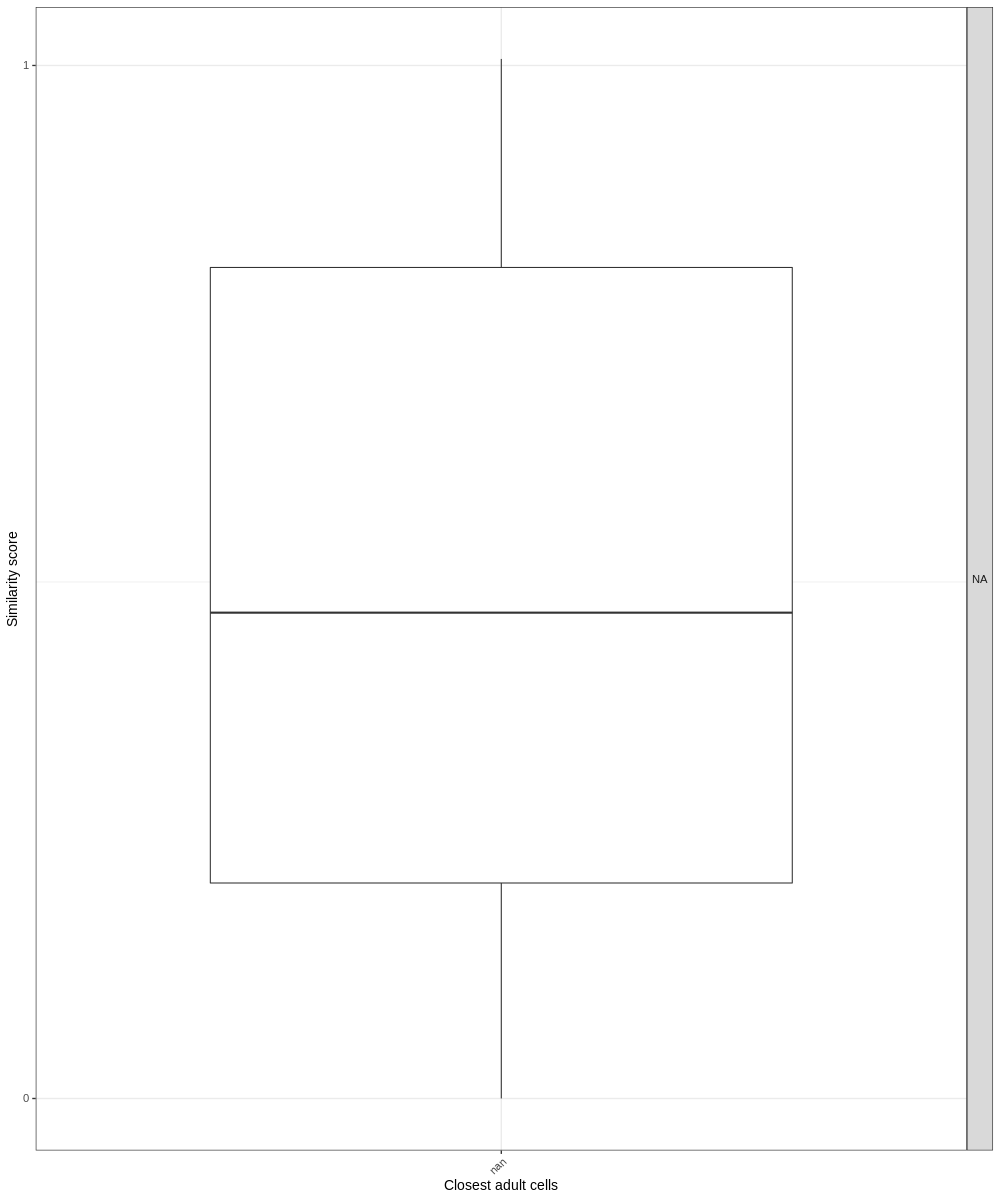

In [339]:
%%R -w 1000 -h 1200 -i fetal_sim_df
pl_df <-fetal_sim_df %>%
    group_by(annotation_reference) %>%
    mutate(mean_sim=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    arrange(-mean_sim) %>%
    filter(predicted_anno!="low_confidence") %>%
    mutate(annotation_reference=factor(annotation_reference, levels=unique(annotation_reference))) %>%
    group_by(predicted_anno, annotation_reference) %>%
#     summarise(n=n(), mean_similarity=mean(mnn_sim_ratio), sd_similarity=sd(mnn_sim_ratio)) %>%
    mutate(n=n(), mean_similarity=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    filter(n > 5) 
    
pl_df %>%
#     group_by(annotation_reference) %>%
    arrange(-n, -mean_similarity) %>%
    mutate(predicted_anno=factor(predicted_anno, levels=unique(predicted_anno))) %>%
#     mutate(max_sim_anno = predicted_anno[max_sim]) %>%
    ggplot(aes(predicted_anno, mnn_sim_ratio)) +
    geom_boxplot(outlier.size=0.05, varwidth=TRUE) +
    scale_y_continuous(breaks=c(0,1)) +
    facet_grid(annotation_reference~.) +
    xlab("Closest adult cells") +
    ylab("Similarity score") +
    theme_bw(base_size=14) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1),
         strip.text.y = element_text(angle=0))

In [318]:
%%R -h 2000 -w 2000 -i adult_annos_order -i figdir

pl_df <- fetal_sim_df %>%
    group_by(annotation_reference) %>%
    mutate(mean_sim=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    arrange(-mean_sim) %>%
    filter(predicted_anno!="low_confidence") %>%
    mutate(annotation_reference=factor(annotation_reference, levels=unique(annotation_reference))) %>%
    filter(mnn_sim_ratio > 0) %>%
    filter(predicted_anno!="low_confidence") %>%
    group_by(predicted_anno, annotation_reference) %>%
#     summarise(n=n(), mean_similarity=mean(mnn_sim_ratio), sd_similarity=sd(mnn_sim_ratio)) %>%
    mutate(n=n(), mean_similarity=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    filter(n > 10) %>%
    mutate(predicted_anno=factor(predicted_anno, levels=adult_annos_order[adult_annos_order %in% predicted_anno])) 



# ----- This section prepare a dataframe for labels ---- #
# Get the name and the y position of each label
label_data <- data.frame(predicted_anno=levels(pl_df[["predicted_anno"]])) %>%
    rowid_to_column()
 
# calculate the ANGLE of the labels
number_of_bar <- length(adult_annos_order)
angle <-  90 - 360 * (label_data$rowid) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
 
# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust<-ifelse( angle < -90, 1, 0)
 
# flip angle BY to make them readable
label_data$angle<-ifelse(angle < -90, angle+180, angle)
# ----- ------------------------------------------- ---- #

plot_swatch <- function(pl_df, anno){
    small_pl_df <- pl_df  %>%
            left_join(label_data) %>%
            mutate(predicted_anno=factor(predicted_anno, levels=adult_annos_order[adult_annos_order %in% predicted_anno])) 
    angles <- small_pl_df %>% filter(annotation_reference==anno)%>% 
        group_by(predicted_anno) %>% 
        summarise(mnn_sim_ratio=1.3, angle=first(angle), hjust=first(hjust))
    small_pl_df %>%
    ggplot(aes(predicted_anno, mnn_sim_ratio)) +
    geom_point(size=0, width=0.5, alpha=0.1, color=NA) +
    ggbeeswarm::geom_quasirandom(data= . %>% filter(annotation_reference==anno), size=0.5, width=0.5, color="red") +
    geom_text(data =  . %>% filter(annotation_reference==anno)%>% group_by(predicted_anno) %>% summarise(mnn_sim_ratio=1.1, angle=first(angle), hjust=first(hjust)), 
               aes( label=predicted_anno,
                   hjust=hjust,
                  ),angle=angles$angle, size=6) +
    theme_classic(base_size=18) +
    geom_hline(yintercept=1) +
    coord_polar() +
    expand_limits(y = c(0,3)) +
    scale_fill_viridis_c() +
    ylab("Similarity score") +
    xlab("") +
#     ggbeeswarm::geom_quasirandom(size=0.05, width=0.5, alpha=0.1) +
    scale_y_continuous(breaks=c(0,1)) +
    theme(axis.text.x = element_blank(),
         strip.text.y = element_text(angle=0),
          
         ) +
    ggtitle(anno)
}

for (a in levels(pl_df$annotation_reference)){
    plot_swatch(pl_df, a) + ggsave(paste0(figdir, "similarity_swatch_", str_replace_all(a, "/", "_"), ".pdf"), width=12, height=8)
}

Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining,

In [319]:
%%R
head(pl_df)
# plot_swatch(pl_df, "MACROPHAGE_II")

  mnn_sim_ratio predicted_anno annotation_reference  mean_sim   n
1    0.02715194            aDC         MIGRATORY_DC 0.1721438 270
2    0.03315634            aDC         MIGRATORY_DC 0.1721438 270
3    0.23906593            aDC         MIGRATORY_DC 0.1721438 270
4    0.07445340            aDC         MIGRATORY_DC 0.1721438 270
5    0.02863438            aDC         MIGRATORY_DC 0.1721438 270
6    0.18233874            aDC         MIGRATORY_DC 0.1721438 270
  mean_similarity
1       0.2346269
2       0.2346269
3       0.2346269
4       0.2346269
5       0.2346269
6       0.2346269


Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"


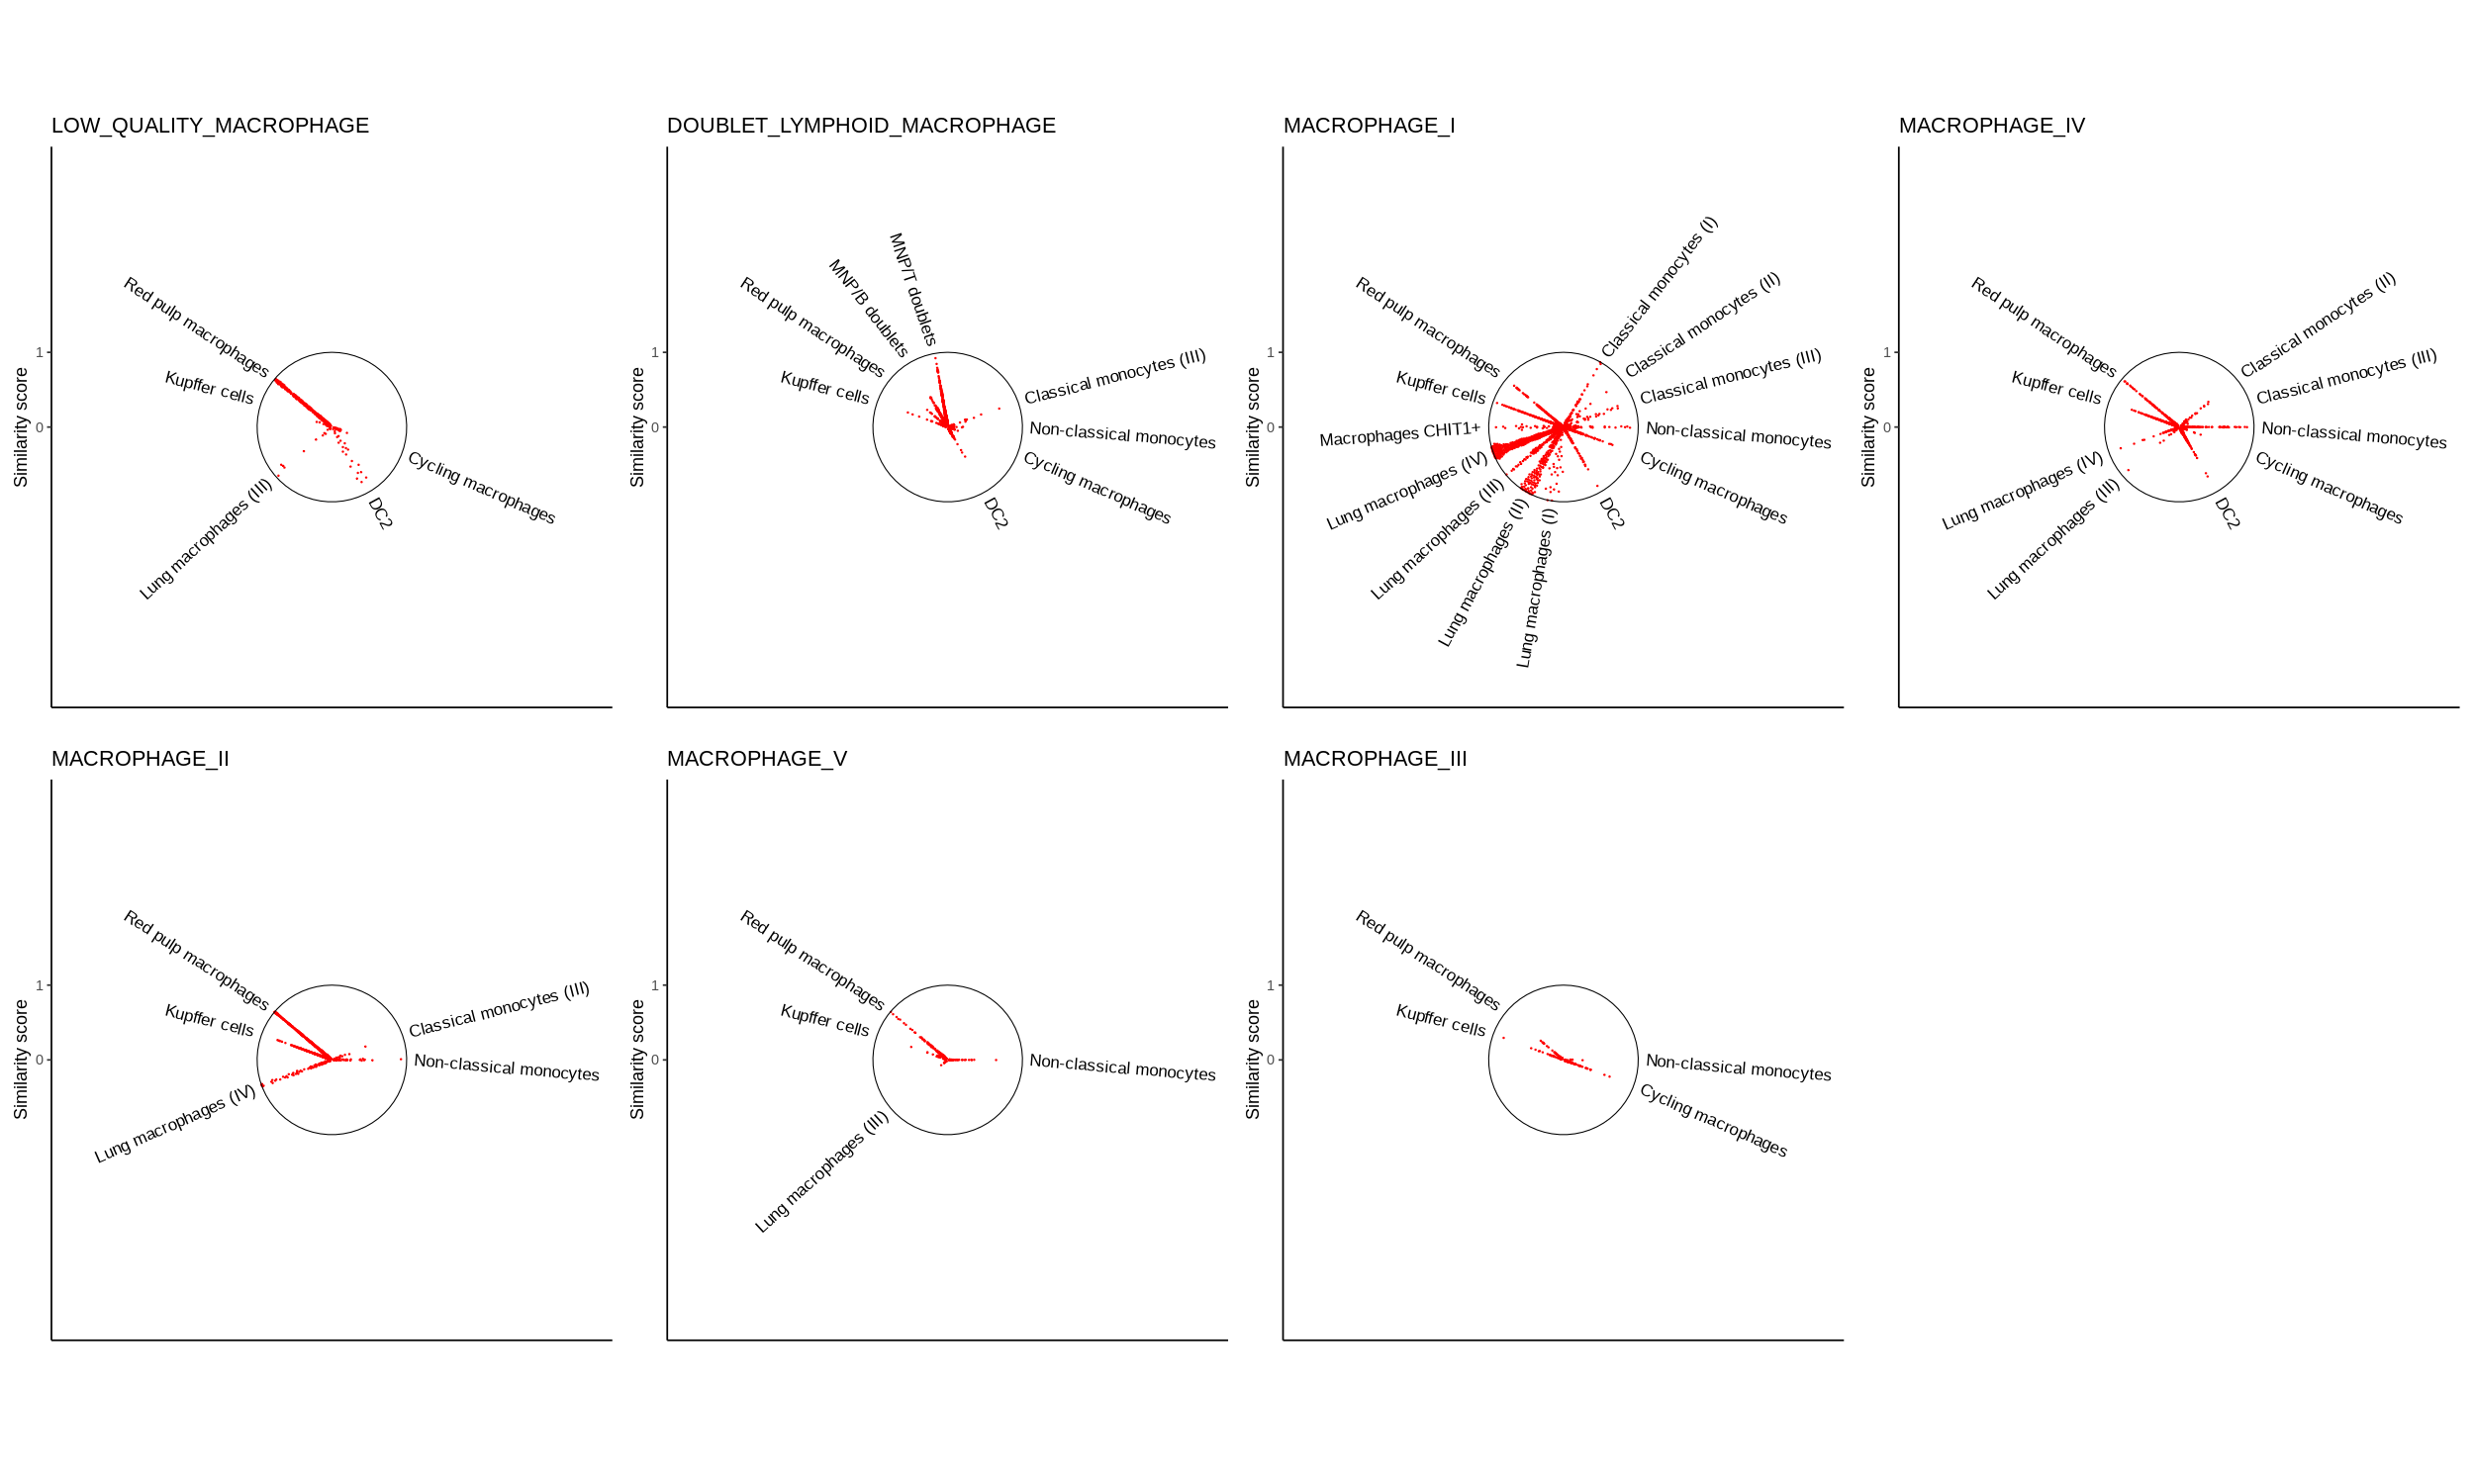

In [317]:
%%R -w 2500 -h 1500
mac_labels <- str_subset(levels(pl_df$annotation_reference), "MACROPHAGE")
pl_ls <- lapply(mac_labels, plot_swatch)
wrap_plots(pl_ls, ncol=4, nrow=2)

#### Transfer labels by organ

In [258]:
merged_adata.obs["annotation_reference_org"] = merged_adata.obs["annotation_reference"].astype("str") + "_" + merged_adata.obs["organ"].astype("str")
merged_adata.obs["annotation_query_org"] = merged_adata.obs["annotation_query"].astype("str") + "_" + merged_adata.obs["organ code"].astype("str")

In [260]:
sns.set_context("talk")
query_anno_col="annotation_query_org"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

conf_mat = get_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

In [267]:
conf_mat.loc[conf_mat.index.str.endswith('_SPL'),:].sum(1)

annotation_query_org
Classical monocytes (I)_SPL      1.0
Classical monocytes (II)_SPL     1.0
Classical monocytes (III)_SPL    1.0
Cycling macrophages_SPL          1.0
DC1_SPL                          1.0
DC2_SPL                          1.0
Intermediate monocytes_SPL       1.0
Kupffer cells_SPL                1.0
Lung macrophages (I)_SPL         1.0
Lung macrophages (III)_SPL       1.0
Lung macrophages (IV)_SPL        1.0
MNP/B doublets_SPL               1.0
MNP/T doublets_SPL               1.0
Non-classical monocytes_SPL      1.0
Red pulp macrophages_SPL         1.0
aDC_SPL                          1.0
dtype: float64

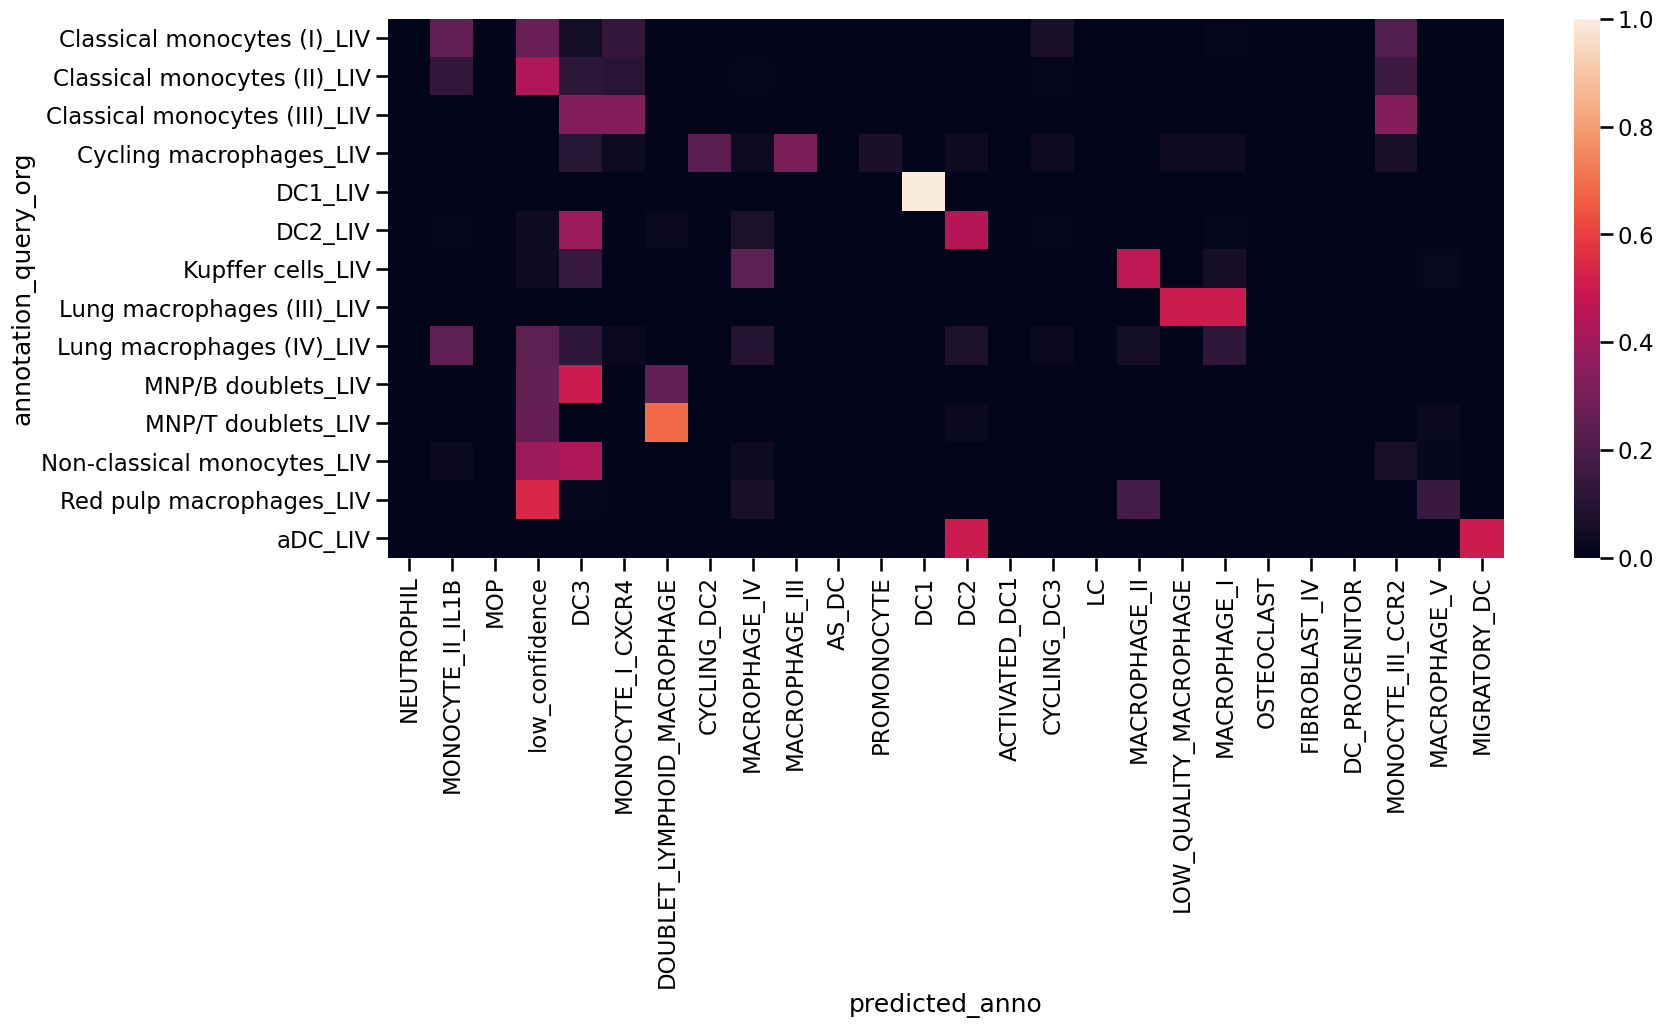

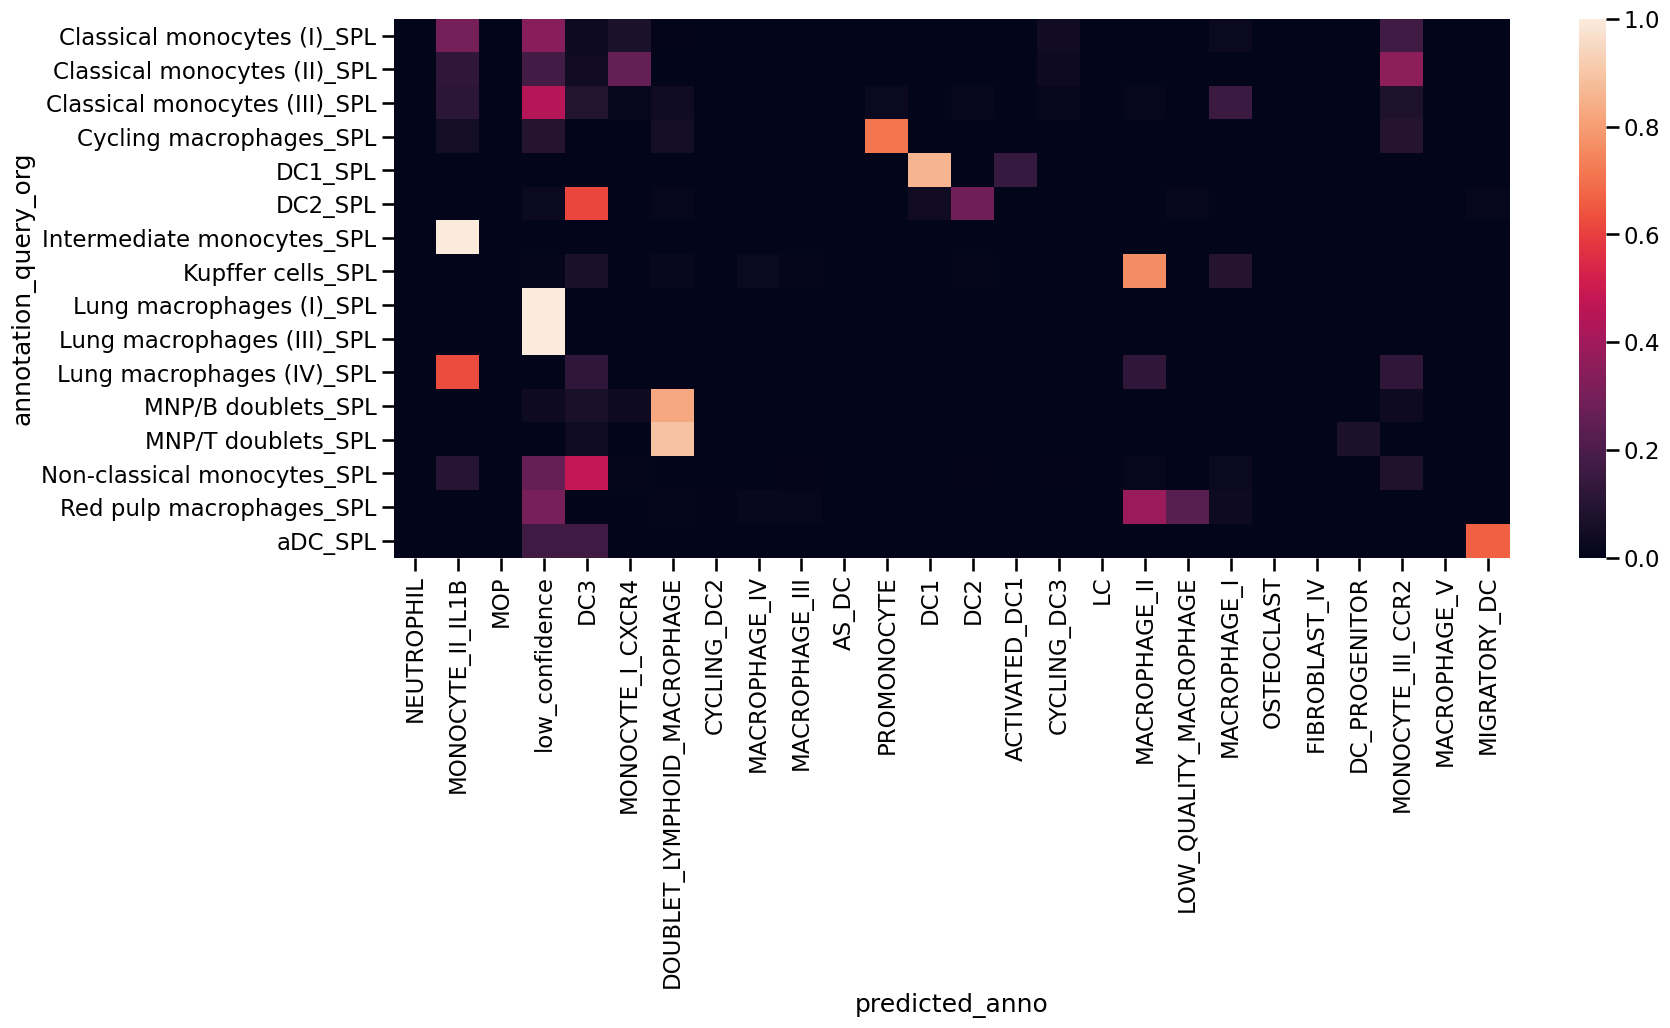

In [264]:
sns.heatmap(conf_mat.loc[conf_mat.index.str.endswith('_LIV'),:]);
plt.show()
sns.heatmap(conf_mat.loc[conf_mat.index.str.endswith('_SPL'),:]);

In [268]:
merged_adata.obs["annotation_reference_org"] = merged_adata.obs["annotation_reference_org"].astype("str").replace("nan_nan", np.nan)
merged_adata.obs["annotation_reference_org"] = merged_adata.obs["annotation_reference_org"].astype("str").replace("nan", np.nan)

if 'predicted_anno' in merged_adata.obs.columns:
    merged_adata.obs.drop('predicted_anno', 1, inplace=True)
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

In [269]:
def get_confusion_mat(adata, query_anno_col, show_low_confidence=True, **kwargs):
    missing_anno = adata.obs["dataset"] == "query"
    if show_low_confidence:
        conf_mat = sc.metrics.confusion_matrix(query_anno_col,"predicted_anno",  adata[missing_anno].obs, normalize=True)
    else:
        high_conf_prediction = adata.obs["predicted_anno"] != "low_confidence"
        conf_mat = sc.metrics.confusion_matrix(query_anno_col,"predicted_anno",  adata[missing_anno & high_conf_prediction].obs, normalize=True)
#     conf_mat.columns = conf_mat.columns.str.upper()
#     conf_mat.columns = conf_mat.columns.str.replace(" ", "_")
    col_order = conf_mat.idxmax(0).sort_values().index
    conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal
    return(conf_mat)


In [300]:
sns.set_context("talk")
query_anno_col="annotation_query_org"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
## Remove query cells with no annotation
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
## Keep query classes with at least 10 cells
class_counts = merged_adata.obs[query_anno_col].value_counts()
remove_class = class_counts.index[class_counts <= 10]
small_query = query_obs[merged_adata[query_obs].obs[query_anno_col].isin(remove_class)]

In [301]:
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]
merged_adata_clean = merged_adata_clean [~merged_adata_clean .obs_names.isin(small_query)]

plt.rcParams["figure.figsize"] = [18,7]
conf_mat = get_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)
# plt.savefig(figdir + "confusion_label_transfer.pdf", bbox_inches="tight")

In [302]:
pl_conf_mat = conf_mat.loc[conf_mat.index.str.endswith('_LIV') | conf_mat.index.str.endswith('_SPL'), :]

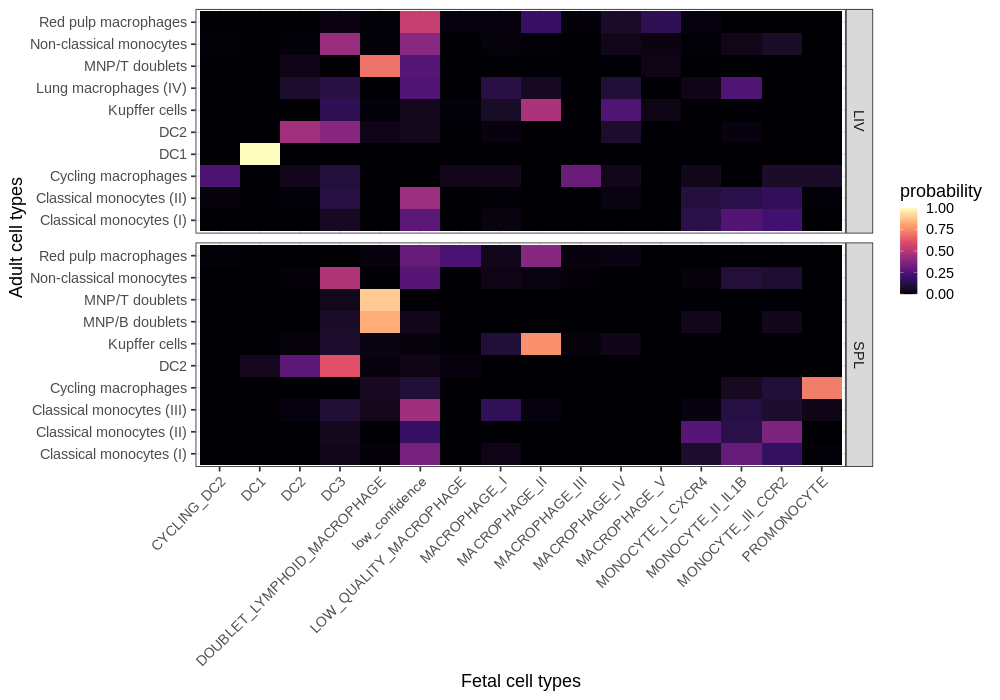

In [304]:
%%R -i pl_conf_mat -w 1000 -h 700
rownames_to_column(pl_conf_mat, "query_anno_org") %>%
 pivot_longer(cols=-query_anno_org, names_to="reference_anno_org", values_to="probability") %>%
    separate(query_anno_org, into=c('query_anno', "query_org"), sep="_") %>%
#     mutate(reference_org=ifelse(str_detect(reference_anno_org, "_SP$"), "SP", "LI")) %>%
    group_by(reference_anno_org) %>%
    mutate(max_prob = max(probability)) %>%
    filter(max_prob > 0.1) %>%
    ungroup() %>%
    filter(query_org %in% c("LIV", "SPL")) %>%
    ggplot(aes(reference_anno_org, query_anno)) +
    geom_tile(aes(fill=probability)) +
    facet_grid(query_org~., scales="free", space="free") +
    scale_fill_viridis_c(option="magma") +
    theme_bw(base_size=18) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    xlab("Fetal cell types") + ylab("Adult cell types")

In [249]:
pl_conf_mat = conf_mat.loc[conf_mat.index.str.endswith('_LIV') | conf_mat.index.str.endswith('_SPL'), conf_mat.columns.str.endswith('_LI') | conf_mat.columns.str.endswith('_SP')]

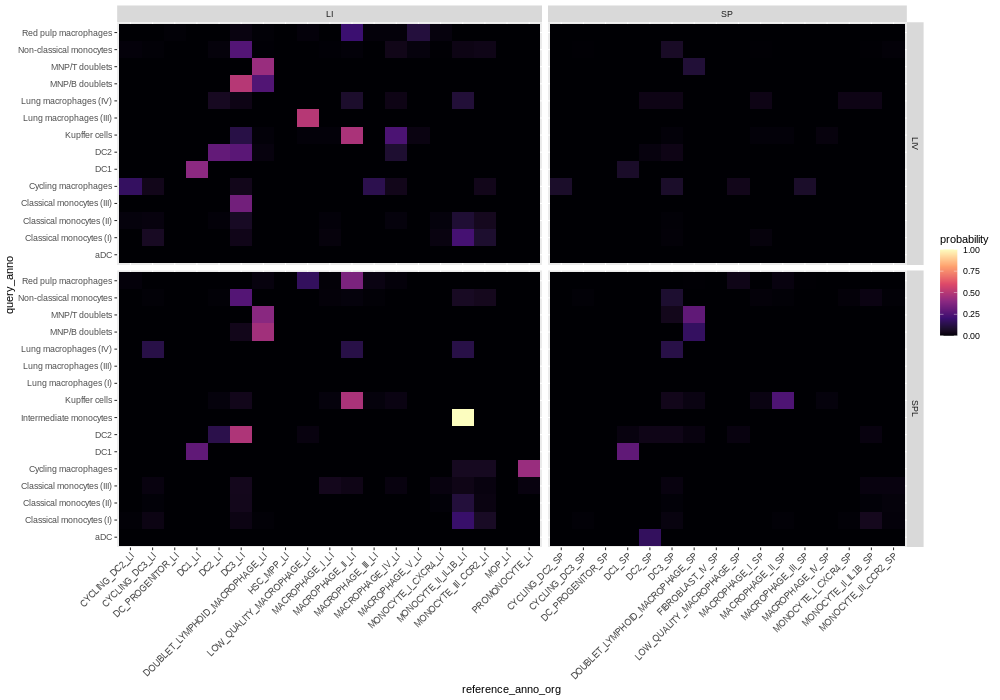

In [253]:
%%R -i pl_conf_mat -w 1000 -h 700
rownames_to_column(pl_conf_mat, "query_anno_org") %>%
 pivot_longer(cols=-query_anno_org, names_to="reference_anno_org", values_to="probability") %>%
    separate(query_anno_org, into=c('query_anno', "query_org"), sep="_") %>%
    mutate(reference_org=ifelse(str_detect(reference_anno_org, "_SP$"), "SP", "LI")) %>%
    filter(query_org %in% c("LIV", "SPL")) %>%
    filter(reference_org %in% c("LI", "SP")) %>%
    ggplot(aes(reference_anno_org, query_anno)) +
    geom_tile(aes(fill=probability)) +
    facet_grid(query_org~reference_org, scales="free", space="free") +
    scale_fill_viridis_c(option="magma") +
    theme(axis.text.x=element_text(angle=45, hjust=1))

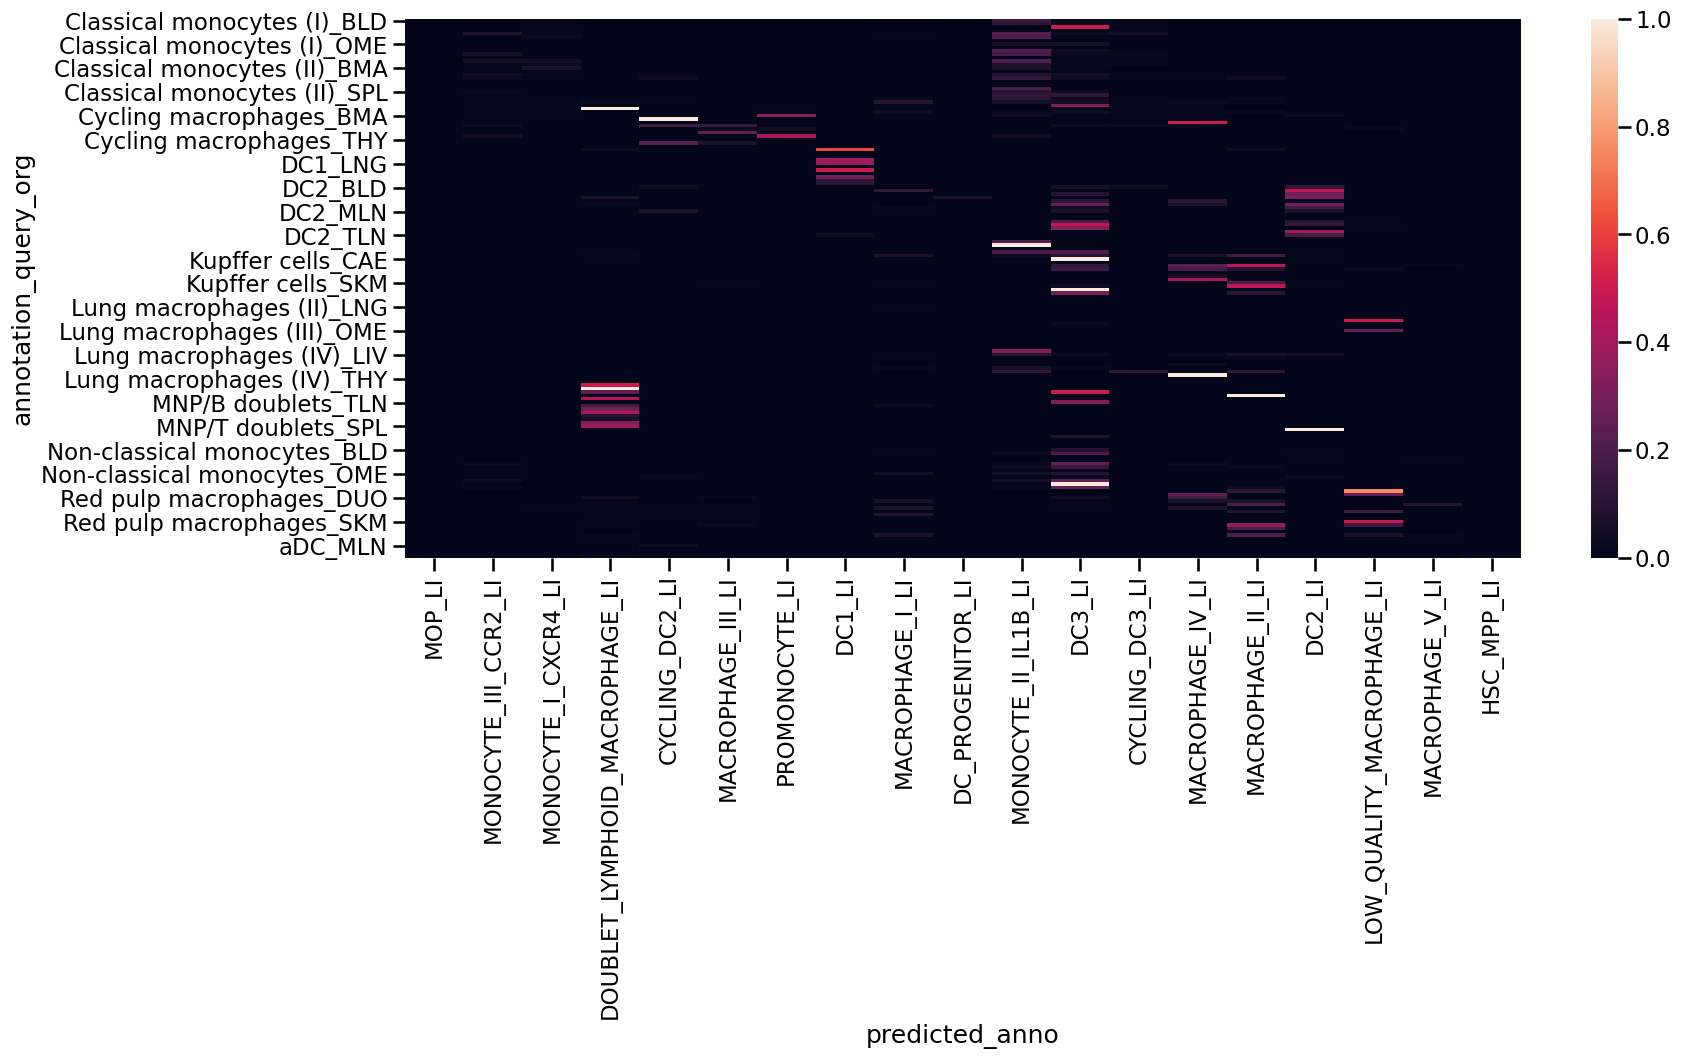

<AxesSubplot:xlabel='predicted_anno', ylabel='annotation_query_org'>

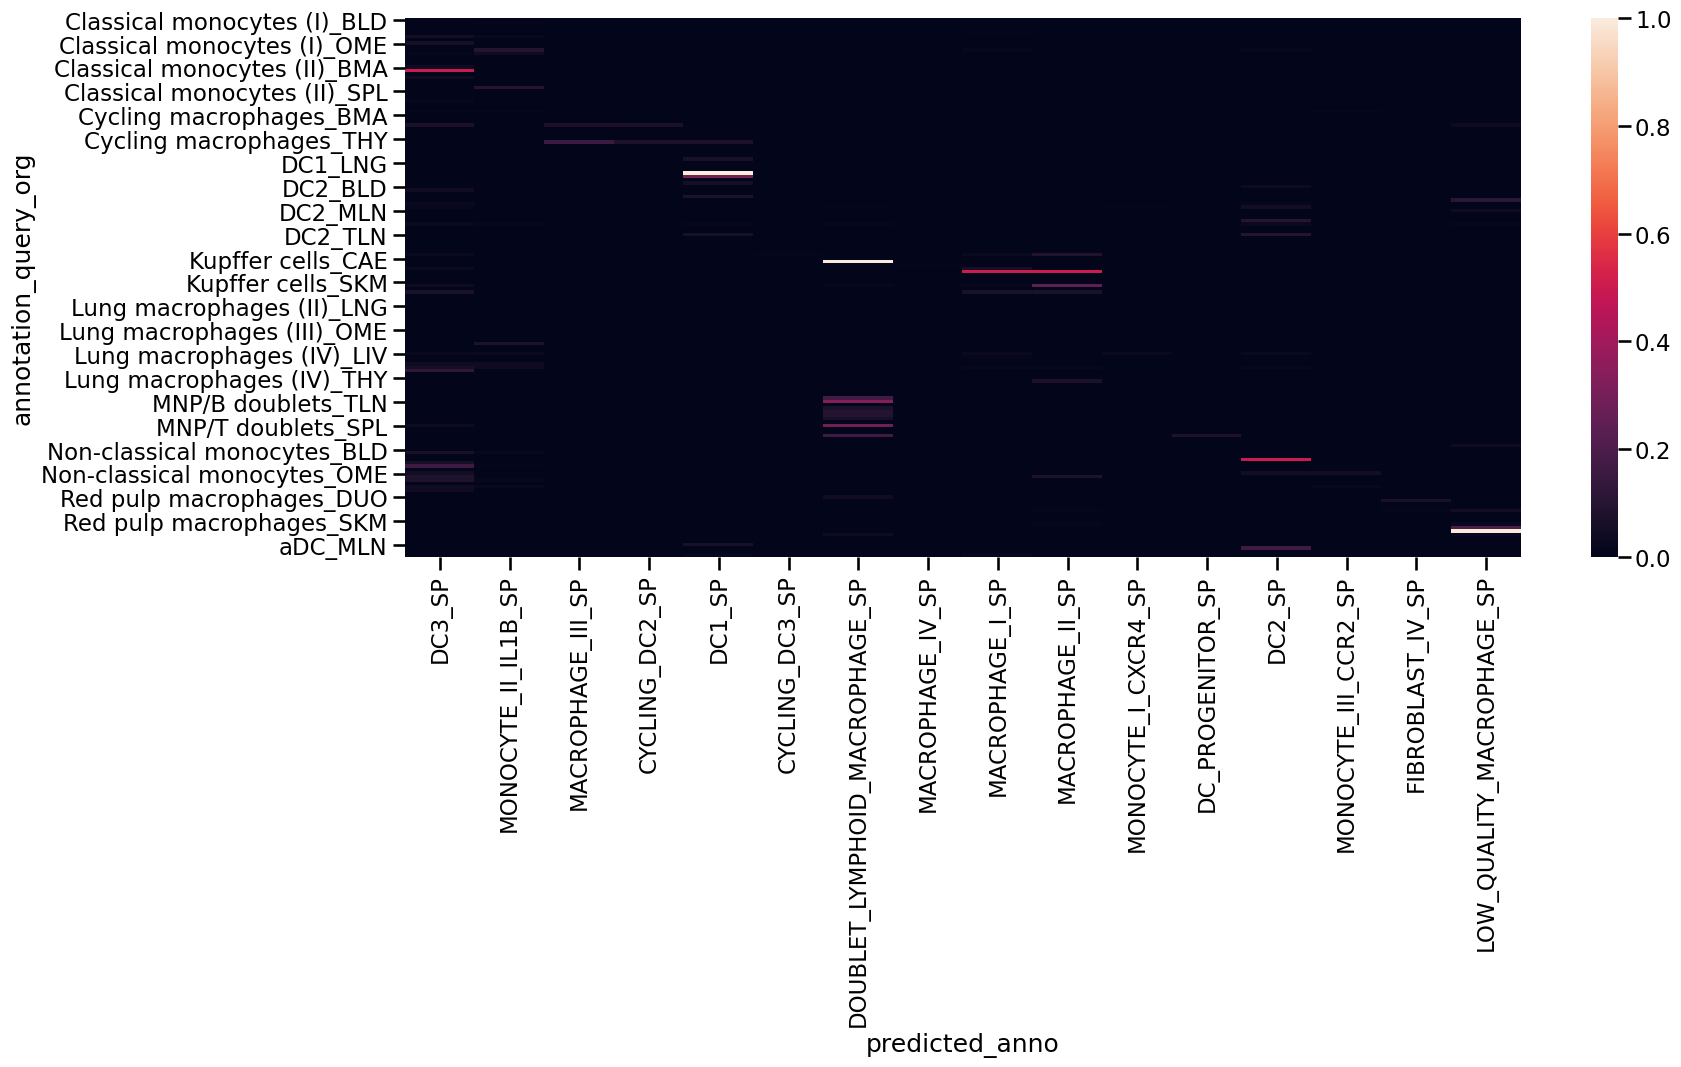

In [231]:
sns.heatmap(conf_mat.loc[:,conf_mat.columns.str.endswith('_LI')])
plt.show()
sns.heatmap(conf_mat.loc[:,conf_mat.columns.str.endswith('_SP')])

In [29]:
import time
start = time.time()
mnn_query, mnn_ref = map_query_utils._find_MNNs(merged_adata)
end = time.time()
print(end - start)

21.743743658065796


In [30]:
map_query_utils._MNN_to_KNN_similarity_ratio(merged_adata, mnn_ref, mnn_query)

... storing 'annotation_reference' as categorical
... storing 'predicted_anno' as categorical


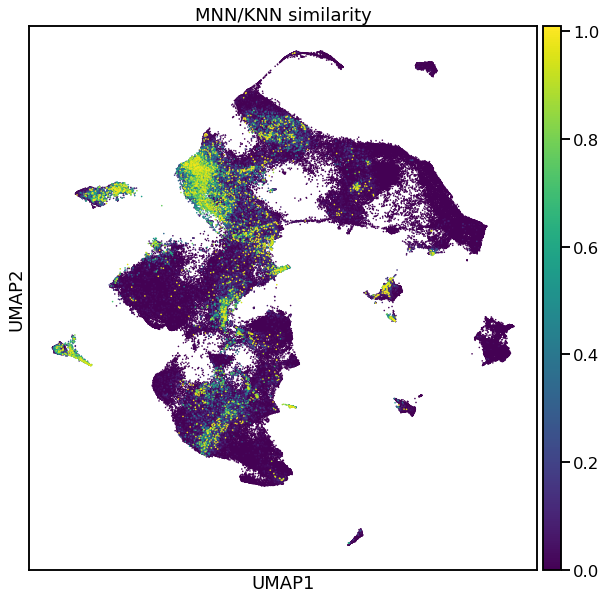

In [31]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
sc.pl.umap(merged_adata, color="mnn_sim_ratio", size=10, title="MNN/KNN similarity")